In [0]:
from __future__ import print_function
import numpy as np
import torch
import torch.autograd as ag

from matplotlib import pyplot
from tqdm import trange
import pandas as pd
import cv2
import glob
import pickle
from matplotlib import pyplot as plt

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x55c72e340000 @  0x7f863942a2a4 0x55c6d6ecef18 0x55c6d6fc2a85 0x55c6d6ee24ca 0x55c6d6ee7232 0x55c6d6edfd0a 0x55c6d6ee75fe 0x55c6d6edfd0a 0x55c6d6ee75fe 0x55c6d6edfd0a 0x55c6d6ee75fe 0x55c6d6edfd0a 0x55c6d6ee7c38 0x55c6d6edfd0a 0x55c6d6ee75fe 0x55c6d6edfd0a 0x55c6d6ee75fe 0x55c6d6ee7232 0x55c6d6ee7232 0x55c6d6edfd0a 0x55c6d6ee7c38 0x55c6d6ee7232 0x55c6d6edfd0a 0x55c6d6ee7c38 0x55c6d6edfd0a 0x55c6d6ee7c38 0x55c6d6edfd0a 0x55c6d6ee75fe 0x55c6d6edfd0a 0x55c6d6edf629 0x55c6d6f1061f


In [0]:
# categories = glob.glob('pokemon/PokemonTypesDeepLearning/Images/data/*')
# xtrain = []
# ltrain = []
# for cat in categories:
#     image_files = glob.glob(cat + "/*")
#     for image in image_files:
#         img = cv2.imread(image, 1)
#         if img.shape == (32, 32, 3) and  image.endswith("Pikachu.png"):
#             xtrain.append(img)
#             ltrain.append(cat.split("/")[-1])
#             print(image)
#             break
def convert(img):
    img = img [:,:,[2,1,0]]
    img = img - img.min()
    img = img/ img.max()
    return img
# plt.imshow(convert(xtrain[210]))
# plt.show()
# plt.imshow(convert(xtrain[0]))
# plt.show()
# plt.imshow(convert(xtrain[0]))

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
cd "/content/drive/My Drive/UCSD/Courses/ECE285 MLIP/Project"

/content/drive/My Drive/UCSD/Courses/ECE285 MLIP/Project


In [0]:
# Loading from xtrain
with open('pokemon_xtrain.pickle', 'rb') as handle:
    xtrain = pickle.load(handle)

with open('pokemon_ltrain.pickle', 'rb') as handle:
    ltrain = pickle.load(handle)

In [0]:
# len(xtrain), len(ltrain), [xtrain[i].shape for i in range(len(ltrain))]

In [0]:
xtrain = np.array(xtrain)
ltrain = np.array(ltrain)

In [10]:
classes = list(set(ltrain))
print(classes)
all_inds = []
for clas in classes:
    inds = (np.where(ltrain == clas)[0])

    inds = np.random.choice(inds, 200)
    all_inds.extend(inds)

ltrain = ltrain[all_inds]
xtrain = xtrain[all_inds]

['Steel', 'Dark', 'Electric', 'Normal', 'Fire', 'Psychic', 'Fighting', 'Poison', 'Dragon', 'Water', 'Ghost', 'Ice', 'Rock', 'Fairy', 'Grass', 'Bug', 'Ground']


In [11]:
sci = np.arange(len(xtrain))
np.random.shuffle(sci)
sci

array([1172, 2918,  669, ..., 1286,  850, 2857])

In [0]:
xtrain = xtrain[sci]
ltrain = ltrain[sci]

In [0]:
xtrain = xtrain.astype(np.float64) / xtrain.max()
# xtrain[0][0]

In [0]:

tmp = dict(zip(classes, range(len(classes))))
inds = map(lambda x:tmp[x], ltrain)
one_hot = np.zeros((len(ltrain), len(classes)))
one_hot[range(len(ltrain)), inds] = 1
one_hot.sum(axis=0)
ltrain = one_hot

In [15]:
xtrain = np.moveaxis(xtrain, [1, 2, 3], [2, 3, 1])
xtrain.shape

(3400, 3, 32, 32)

In [0]:
val_idx = np.random.uniform(size=(len(xtrain),)) < 0.2
xval = xtrain[val_idx]
lval = ltrain[val_idx]
neg = (1-val_idx).astype(bool)
xtrain = xtrain[neg]
ltrain = ltrain[neg]

In [17]:
ltrain.shape, lval.shape

((2714, 17), (686, 17))

In [0]:
# with open('pokemon_xtrain_split.pickle', 'wb') as handle:
#     pickle.dump(xtrain, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('pokemon_ltrain_split.pickle', 'wb') as handle:
#     pickle.dump(ltrain, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('pokemon_xval_split.pickle', 'wb') as handle:
#     pickle.dump(xval, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('pokemon_lval_split.pickle', 'wb') as handle:
#     pickle.dump(lval, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('pokemon_classes.pickle', 'wb') as handle:
#     pickle.dump(classes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:

with open('pokemon_xtrain_split.pickle', 'rb') as handle:
    xtrain = pickle.load(handle)

with open('pokemon_ltrain_split.pickle', 'rb') as handle:
    ltrain = pickle.load(handle)

with open('pokemon_xval_split.pickle', 'rb') as handle:
    xval = pickle.load(handle)

with open('pokemon_lval_split.pickle', 'rb') as handle:
    lval = pickle.load(handle)

with open('pokemon_classes.pickle', 'rb') as handle:
    classes = pickle.load(handle)

In [0]:
xtrain = torch.from_numpy(xtrain).double()
ltrain = torch.from_numpy(ltrain).long()
xval = torch.from_numpy(xval).double()
lval = torch.from_numpy(lval).long()

if torch.cuda.is_available():
    xtrain = xtrain.cuda()
    ltrain = ltrain.cuda()
    xval = xval.cuda()
    lval = lval.cuda()

xtrain_target = ag.Variable(xtrain, requires_grad=False)
xtrain = ag.Variable(xtrain, requires_grad=True)
ltrain = ag.Variable(ltrain, requires_grad=False)
xval = ag.Variable(xval, requires_grad=False)
lval = ag.Variable(lval, requires_grad=False)

In [0]:
# ltrain.sum(dim=0), lval.sum(dim=0)

In [23]:
import torch.nn as nn
import torch.nn.functional as F
# This is our neural networks class that inherits from nn.Module 
class LeNet(nn.Module):
# Here we define our network structure
    def __init__(self):
        super(LeNet , self).__init__ () 
        l = len(classes) * 3
        l2 = 84
        l3 = 120
        
        l = 64
        l2 = 256
        l3 = 1024
        
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2).double()
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, 5, padding=2).double()
        self.conv2_bn = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(2048, l3).double() 
        self.fc1_bn = nn.BatchNorm1d(l3)
        self.fc2 = nn.Linear(l3, l2).double() 
        self.fc2_bn = nn.BatchNorm1d(l2)
        self.fc3 = nn.Linear(l2, l).double()
        
        self.fc3r = nn.Linear(l, l2).double()
        self.fc2r = nn.Linear(l2, l3).double() 
#         self.fc2r_bn = nn.BatchNorm1d(l2)
        self.fc1r = nn.Linear(l3, 2048).double() 
#         self.fc1r_bn = nn.BatchNorm1d(l3)
        self.conv2r = nn.Conv2d(32, 32, 5, padding=2).double()
        self.conv3r = nn.Conv2d(32, 32, 5, padding=2).double()
        self.conv4r = nn.Conv2d(32, 32, 5, padding=2).double()


#         self.conv2r_bn = nn.BatchNorm2d(32)
        self.conv1r = nn.Conv2d(32, 3, 5, padding=2).double()
        
        
        self.descriminator_conv1 = nn.Conv2d(3, 32, 5, padding=2).double()
        self.descriminator_conv2 = nn.Conv2d(32, 32, 5, padding=2).double()
        self.descriminator = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2),
            nn.Softmax()
        ).double()
        
        self.classifier = nn.Sequential(
            nn.Linear(l, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 4 * len(classes)),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4 * len(classes), len(classes)),
            nn.Softmax()
        ).double()
        

    def load_my_state_dict(self, state_dict):
 
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                 continue
            if isinstance(param, torch.nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            try:
              own_state[name].copy_(param)
            except:
              continue
            
    # Here we define one forward pass through the network 
    def forward(self, x):
        x, _, _ = self.encode(x)
        x = self.classifier[2](self.classifier[1](self.classifier[0](x)))
       
        y = self.classifier[5](self.classifier[4](self.classifier[3](x)))
        x = y + x
        y = self.classifier[8](self.classifier[7](self.classifier[6](x)))
        x = y + x
#         y = self.classifier[11](self.classifier[10](self.classifier[9](x)))
#         x = y + x
#         y = self.classifier[14](self.classifier[13](self.classifier[12](x)))
#         x = y + x
#         y = self.classifier[17](self.classifier[16](self.classifier[15](x)))
#         x = y + x
#         y = self.classifier[20](self.classifier[19](self.classifier[18](x)))
#         x = y + x
#         y = self.classifier[23](self.classifier[22](self.classifier[21](x)))
#         x = y + x
        x = self.classifier[-3](self.classifier[-4](self.classifier[-5](x)))
        x = (self.classifier[-1](self.classifier[-2](x))).double()
        
        return x
    
    def encode(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1)
#         x = self.conv1_bn(x)
        x, ind1 = F.max_pool2d(x, (2, 2), return_indices=True)
        x = F.leaky_relu(self.conv2(x),0.1)
#         x = self.conv2_bn(x)
        x, ind2 = F.max_pool2d(x, (2, 2), return_indices=True)
        x = x.view(-1, self.num_flat_features(x))
        x = F.leaky_relu(self.fc1(x),0.1)
#         x = self.fc1_bn(x)
        x = F.leaky_relu(self.fc2(x),0.1)
#         x = self.fc2_bn(x)
        x = F.leaky_relu(self.fc3(x),0.1)
        return x, ind1, ind2
    
    def discriminate(self, x):
        x = F.relu(self.descriminator_conv1(x))
        x, ind1 = F.max_pool2d(x, (2, 2), return_indices=True)
        x = F.relu(self.descriminator_conv2(x))
        x, ind2 = F.max_pool2d(x, (2, 2), return_indices=True)
        x = x.view(-1, self.num_flat_features(x))
        x = self.descriminator(x)
        return x
    
    def generator(self, x):
        bs = x.size()[0]
#         ind1 = torch.stack([torch.stack([torch.arange(0, 16*16 * 2, 2).view(-1, 16) for i in range(32)]) for i in range(bs)])
        ind1 = torch.stack([torch.stack([torch.arange(0, 16*16 * 2, 2).view(-1, 16) for i in range(32)]) for i in range(bs)])
#         ind2 = torch.stack([torch.stack([torch.arange(0, 8*8 * 2, 2).view(-1, 8) for i in range(32)]) for i in range(bs)])
        ind2 = torch.stack([torch.stack([torch.arange(0, 8*8 * 2, 2).view(-1, 8) for i in range(32)]) for i in range(bs)])
        ind1 = ag.Variable(ind1.long().cuda(), requires_grad=False)
        ind2 = ag.Variable(ind2.long().cuda(), requires_grad=False)
        return self.decode(x, ind1, ind2)
    
    def decode(self, x, ind1, ind2):
        x = F.leaky_relu(self.fc3r(x),0.1)
#         x = self.fc2r_bn(x)
        x = F.leaky_relu(self.fc2r(x), 0.1)
#         x = self.fc1r_bn(x)
        x = F.leaky_relu(self.fc1r(x), 0.1)
        x = x.view(-1, 32, 8, 8)
        x = F.max_unpool2d(x, ind2, (2, 2), padding=(0,0), stride=(2, 2))
        x = F.leaky_relu(self.conv2r(x), 0.1)
#         x = self.conv2r_bn(x)
        x = F.max_unpool2d(x, ind1, (2, 2), padding=(0,0), stride=(2, 2))
        x = F.leaky_relu(self.conv4r(x), 0.1)
        x = F.leaky_relu(self.conv3r(x), 0.1)
        x = F.leaky_relu(self.conv1r(x), 0.1).double()
        return x
    
    def auto_encode_forward(self , x):
        x, ind1, ind2 = self.encode(x)
        x = self.decode(x, ind1, ind2)
        return x

    # Determine the number of features in a batch of tensors 
    def num_flat_features(self , x):
        size = x.size()[1:]
        return np.prod(size)

net = LeNet()

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal(m.weight)
        m.bias.data.fill_(0.01)

net.apply(init_weights)

print(net)
if torch.cuda.is_available():
    net=net.cuda()
    


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:189: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc2_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc3r): Linear(in_features=64, out_features=256, bias=True)
  (fc2r): Linear(in_features=256, out_features=1024, bias=True)
  (fc1r): Linear(in_features=1024, out_features=2048, bias=True)
  (conv2r): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3

In [0]:
net.load_my_state_dict(torch.load('auto_gan.net'))

In [0]:
yinit = net(xval)
if torch.cuda.is_available():
    yinit = yinit.cpu()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:121: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
yinit.data.numpy().shape
lval.shape

torch.Size([723, 17])

In [0]:
print (100 * np.mean(lval.cpu().data.numpy().T.argmax(axis=0) == yinit.data.numpy().T.argmax(axis =0)))

5.117565698478561


Train Auto Encoder

In [0]:
for param in net.parameters():
    param.requires_grad = True

In [0]:
import math
N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 40
# T = 1
gamma = .0001
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.MSELoss() 
# optimizer = torch.optim.SGD(net.parameters(), lr=gamma , momentum=rho)
optimizer = torch.optim.Adam(net.parameters(), lr=gamma)

In [0]:
# net.load_state_dict(torch.load('auto_64.net'))


In [0]:


losses = []
for epoch in range(T): 
    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    br = False
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
        labels = xtrain_target[idxsmp]
        # Initialize the gradients to zero 
        optimizer.zero_grad()

        # Forward propagation 
        outputs = net.auto_encode_forward(inputs)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)
        loss = criterion(outputs , labels)
        
        # Back propagation 
        loss.backward()

        # Parameter update 
        optimizer.step()
        
        voutputs = net.auto_encode_forward(xval[:100])
        vloss = criterion(voutputs[:100] , xval[:100])

        # Print averaged loss per minibatch every 100 mini-batches
        running_loss+= loss[0]
#         print(k)
        losses.append((running_loss.cpu().data.numpy().astype(float), vloss[0].cpu().data.numpy()))
    
        if len(losses) > 31:
#             print(losses)
            if ((np.array(losses[-30:])[:,1] - np.array(losses[-31:-1])[:,1])>0).sum()>20:
                br = True
                break
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f ' % (epoch + 1, k + 1, running_loss), end="")
            running_loss = 0.0 
    if br:
        break

print ( ' Finished Training ' )
# pd.Series(losses).ewm(20).mean().plot()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[38,     6] loss: 0.00267861  Finished Training 


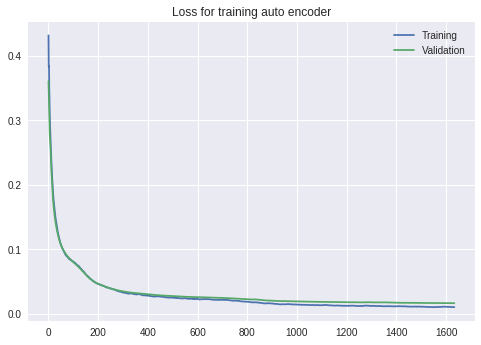

In [0]:
pd.DataFrame(losses[20:], columns=['Training', 'Validation']).ewm(20).mean().plot(title='Loss for training auto encoder')

In [0]:
voutputs = net.auto_encode_forward(xval)
storedv = voutputs
# xval[0].cpu().data.numpy()[0]
# torch.save(net.state_dict(), 'class3.net')

In [0]:
10

10

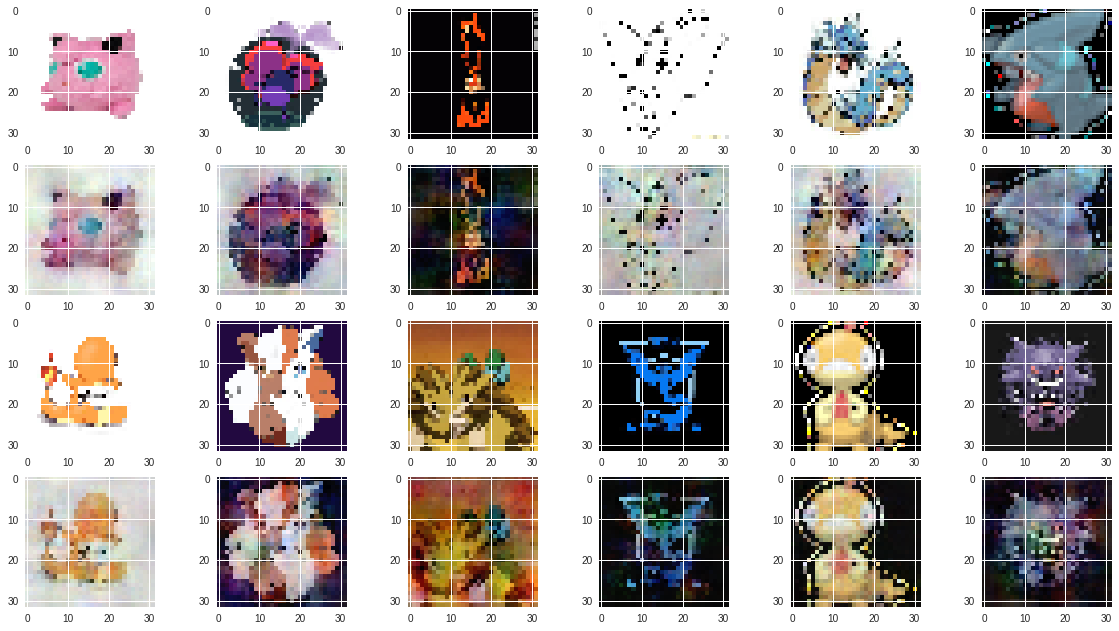

In [0]:
from matplotlib import pyplot as plt


fig, axes = plt.subplots(4, 6, figsize=(20,11))
# plt.title("Images generated with autencoder")
fig.fig_size=(16,9)
for i in range(0, 4, 2):
    for j in range(6):
        vv = voutputs[40+i*6+j].cpu().data.numpy()
        vv = vv - vv.min()
        vv = vv/vv.max()
#         print(vv.max(), vv.min())
        axes[i, j].imshow(convert(xval[40+i*6+j].cpu().data.numpy().transpose([1, 2, 0])))
        axes[i+1, j].imshow(convert(vv.transpose([1, 2, 0])))


In [0]:
#100,10
# 100, 3
def add_image(a, b):
  s1 = xval[[a]]
  s2 = xval[[b]]
  x1, id11, id21 = net.encode(s1)
  x2, id12, id22 = net.encode(s2)
  # print(id22)
  ans = net.decode((x1+x2)/2, id12, id22)
  ans_l = net.decode((3*x1+x2)/4, id12, id22)
  ans_r = net.decode((x1+3*x2)/4, id12, id22)

  ans2 = net.decode((x1+x2)/2, id11, id21)
  ans_l2 = net.decode((3*x1+x2)/4, id11, id21)
  ans_r2 = net.decode((x1+3*x2)/4, id11, id21)
  fig, axes = plt.subplots(1, 4, figsize=(20,11))
  axes[3].imshow(convert(ans[0].cpu().data.numpy().transpose([1, 2, 0])))
#   axes[4].imshow(convert(ans2[0].cpu().data.numpy().transpose([1, 2, 0])))
#   axes[5].imshow(convert(ans_r2[0].cpu().data.numpy().transpose([1, 2, 0])))
#   axes[6].imshow(convert(ans_r[0].cpu().data.numpy().transpose([1, 2, 0])))
#   axes[7].imshow(convert(ans[0].cpu().data.numpy().transpose([1, 2, 0])))
#   axes[8].imshow(convert(ans_l[0].cpu().data.numpy().transpose([1, 2, 0])))

  axes[0].imshow(convert(s1[0].cpu().data.numpy().transpose([1, 2, 0])))
  axes[1].imshow(convert(s2[0].cpu().data.numpy().transpose([1, 2, 0])))
  axes[2].imshow(convert(((s2[0]+s1[0])/2).cpu().data.numpy().transpose([1, 2, 0])))
add_image(100, 10)
# add_image(40, 41)
add_image(58, 59)
add_image(42, 55)
# add_image(6, 2)
# add_image(500, 400)


RuntimeError: ignored

In [0]:
net.load_state_dict(torch.load('auto_gan.net'))


In [0]:
import math
N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 1000
# T = 1
gamma = .001
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=gamma , momentum=rho)
dec_optimizer = torch.optim.Adam(net.parameters(), lr=gamma)
DECO = [net.fc3r, net.fc2r,net.fc1r, net.conv2r, net.conv1r, net.conv3r, net.conv4r]
DECO = reduce(lambda x, y: x+y, list(map(lambda x: [p for p in x.parameters()], DECO)), [])
# print(len(DECO))
generator_optimizer = torch.optim.Adam(DECO, lr=0.00001)

DESC = [net.descriminator_conv1, net.descriminator_conv2, net.descriminator] 
DESC = reduce(lambda x, y: x+y, list(map(lambda x: [p for p in x.parameters()], DESC)), [])
discriminator_optimizer = torch.optim.Adam(DESC, lr=0.0001)

/usr/local/lib/python2.7/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:75: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.

[22,    78] loss: 0.08565278 True Change 
[22,    79] loss: -0.23275996 False

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:78: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[22,    94] loss: -1.07748764 False Change 


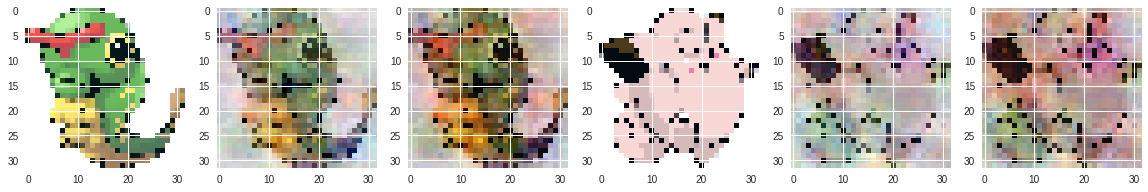

[23,    92] loss: 0.08571305 True Change 
[23,   126] loss: -1.40906268 False Change 


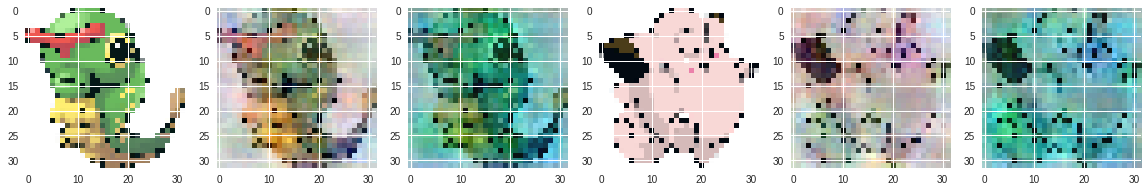

[24,    30] loss: 0.09723085 True Change 
[24,    84] loss: -1.37400856 False Change 


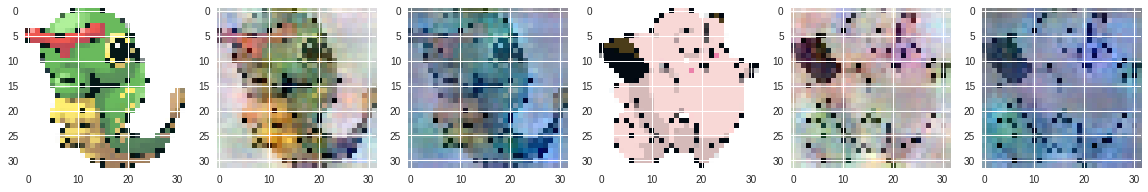

[25,    20] loss: 0.08607412 True Change 
[25,    28] loss: -1.09893725 False Change 


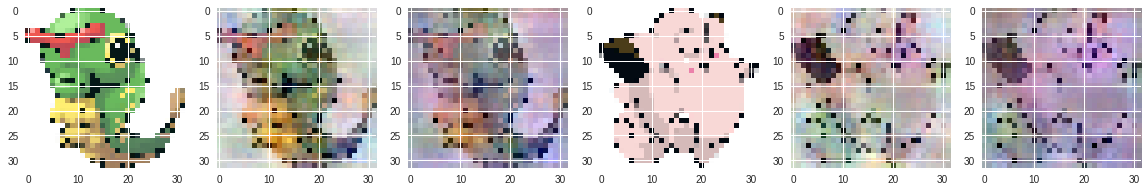

[25,    95] loss: 0.08641162 True Change 
[25,   128] loss: -1.10920467 False Change 


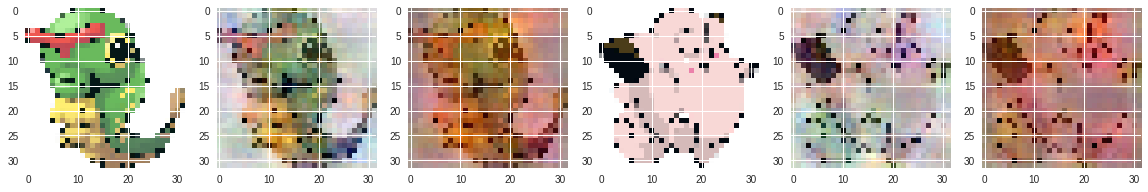

[26,    34] loss: 0.04027489 True Change 
[26,    57] loss: -1.01223576 False Change 


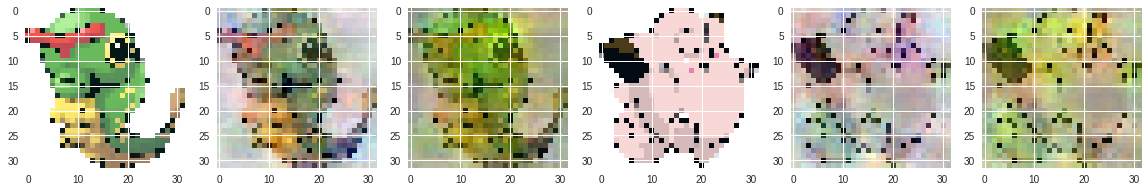

[26,   105] loss: 0.08822691 True Change 
[26,   133] loss: -1.23762298 False Change 


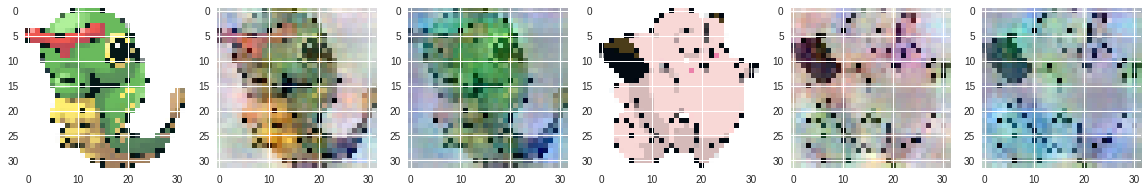

[27,    82] loss: 0.09127918 True Change 
[27,    94] loss: -1.04507744 False Change 


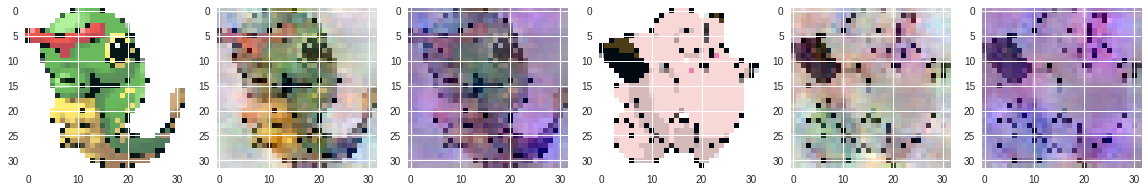

[28,    10] loss: 0.09592181 True Change 
[28,    99] loss: -1.31346521 False Change 


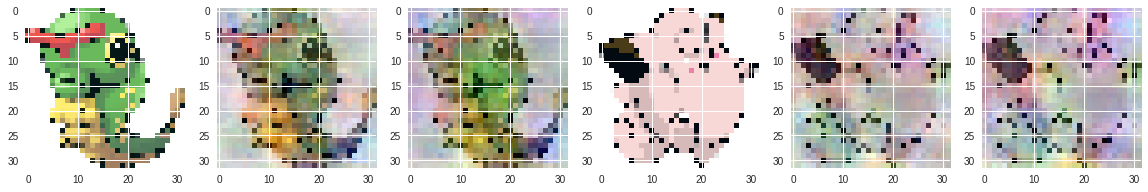

[29,    76] loss: 0.09290101 True Change 
[29,   121] loss: -1.12295171 False Change 


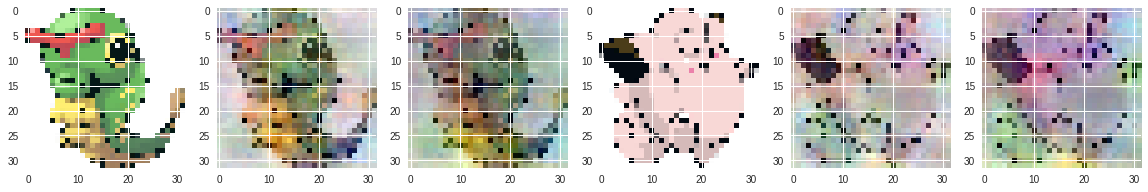

[30,    80] loss: 0.09674589 True Change 
[30,   109] loss: -1.04125547 False Change 


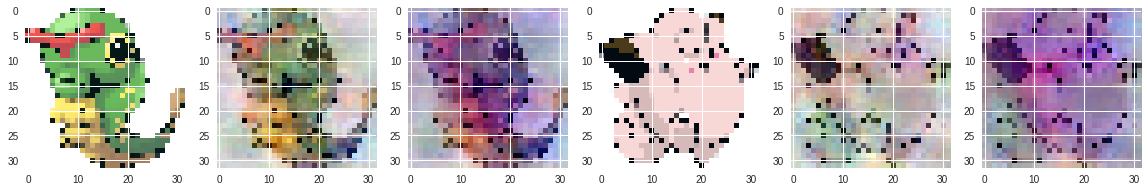

[30,   132] loss: 0.09030616 True Change 
[31,    30] loss: -1.08136676 False Change 


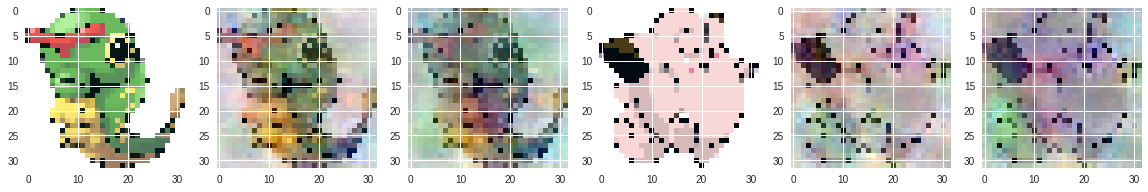

[31,   130] loss: 0.08461759 True Change 
[32,    28] loss: -1.16520485 False Change 


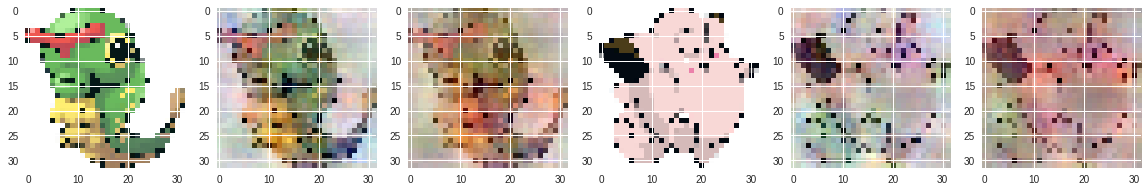

[32,    75] loss: 0.08035940 True Change 
[32,   129] loss: -1.21960073 False Change 


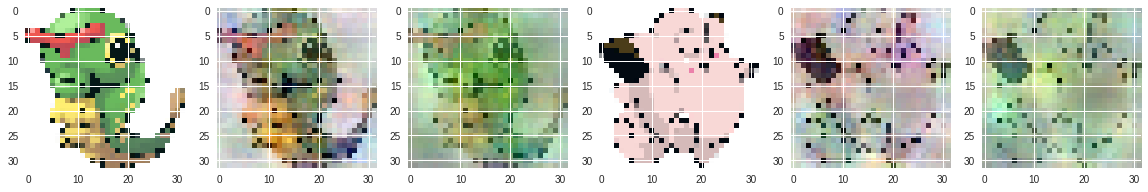

[33,    33] loss: 0.08301607 True Change 
[33,    93] loss: -1.06351023 False Change 


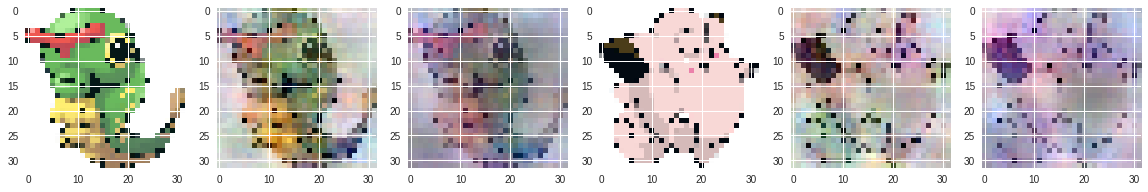

[34,    11] loss: 0.08018932 True Change 
[34,    95] loss: -1.18195998 False Change 


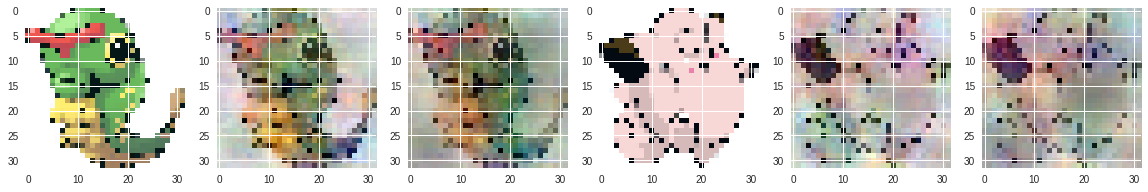

[35,    32] loss: 0.08752009 True Change 
[35,    67] loss: -1.25412705 False Change 


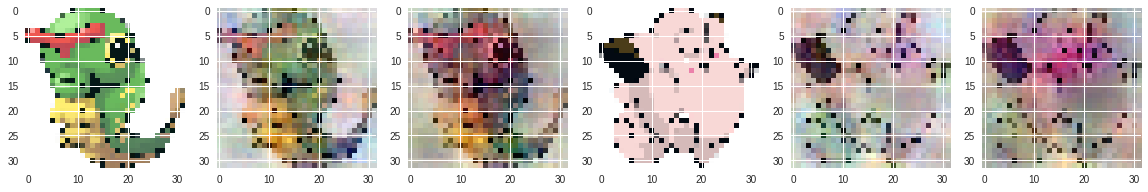

[35,   125] loss: 0.09993675 True Change 
[36,    42] loss: -1.00539380 False Change 


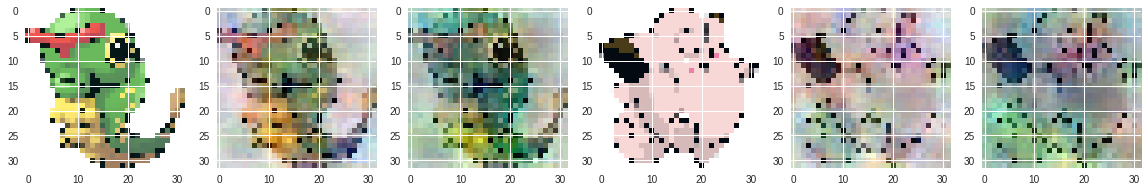

[36,    81] loss: 0.09461134 True Change 
[36,   100] loss: -1.08944533 False Change 


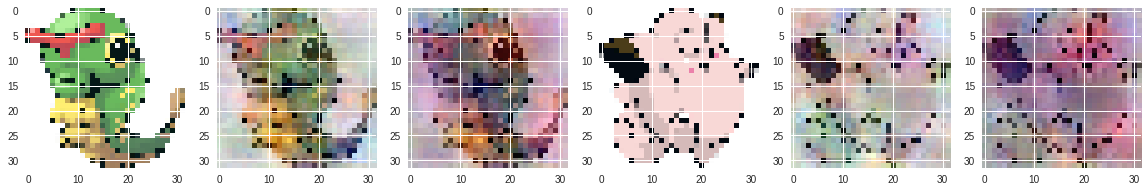

[37,     5] loss: 0.08474511 True Change 
[37,    39] loss: -1.11798201 False Change 


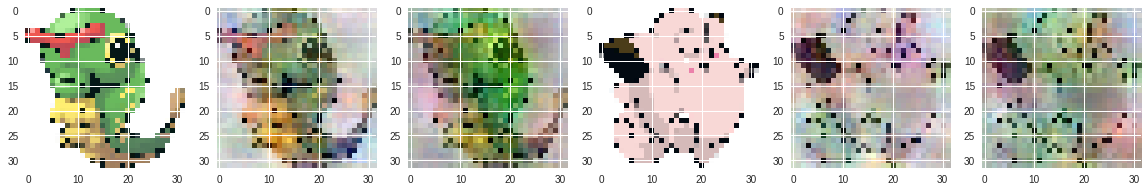

[37,    71] loss: 0.08951052 True Change 
[37,   121] loss: -1.00021282 False Change 


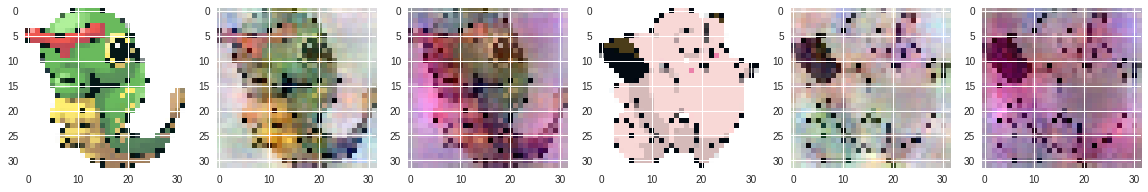

[38,    30] loss: 0.09983518 True Change 
[38,    66] loss: -1.00438167 False Change 


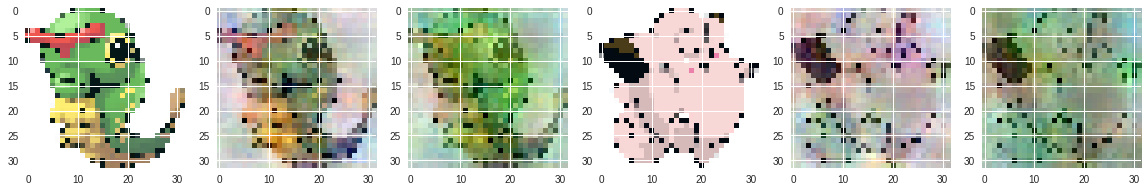

[38,   108] loss: 0.08966892 True Change 
[39,    16] loss: -1.07657396 False Change 


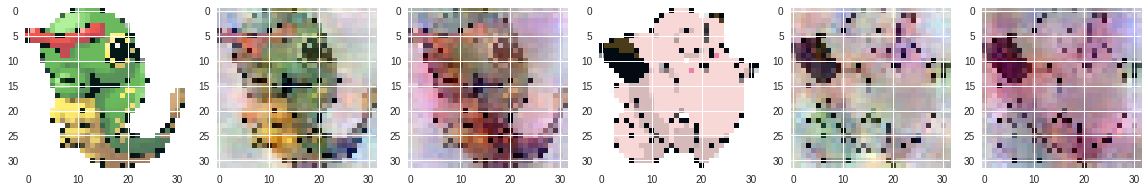

[39,    69] loss: 0.09921119 True Change 
[39,   113] loss: -1.09807179 False Change 


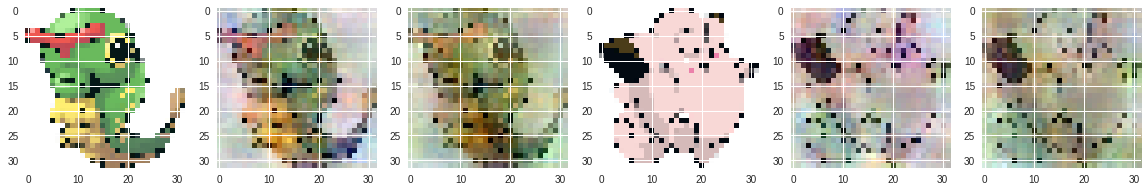

[40,    51] loss: 0.09950732 True Change 
[40,    78] loss: -1.02932829 False Change 


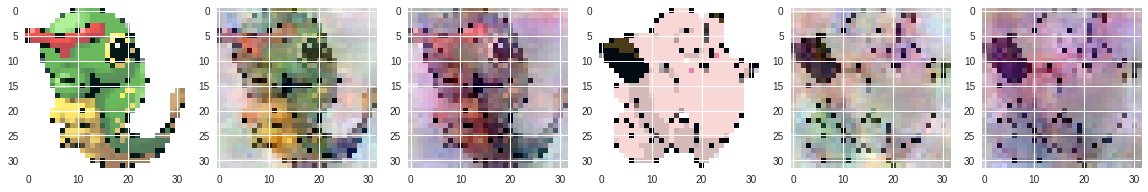

[40,   105] loss: 0.09505317 True Change 
[41,     5] loss: -1.29053672 False Change 


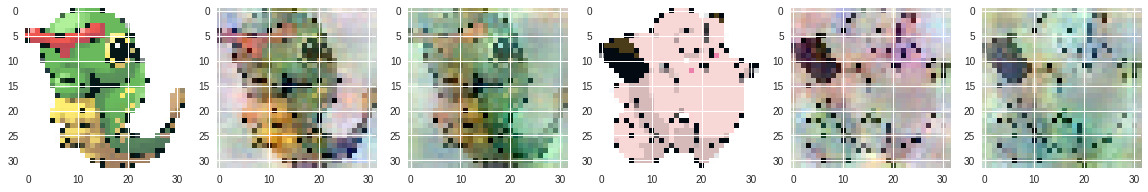

[41,    42] loss: 0.04635870 True Change 
[41,    80] loss: -1.28742470 False Change 


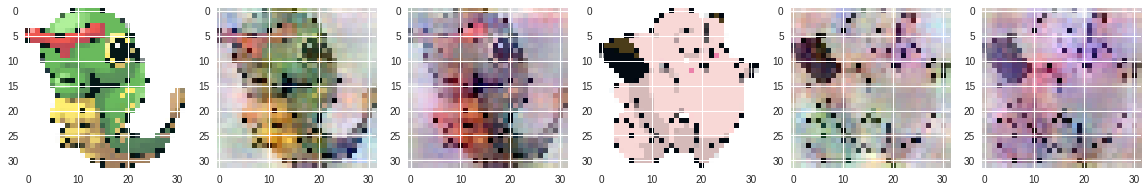

[42,     9] loss: 0.09858368 True Change 
[42,    22] loss: -1.06922228 False Change 


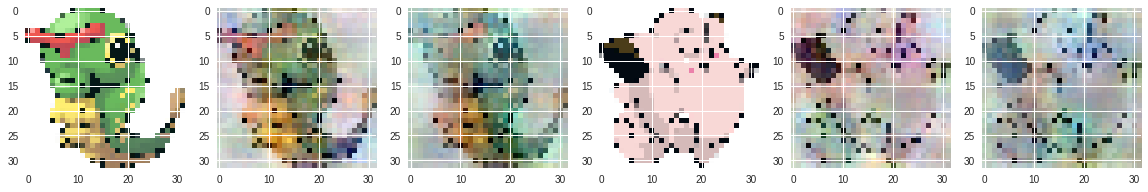

[42,    66] loss: 0.08487462 True Change 
[43,    47] loss: -1.06420266 False Change 


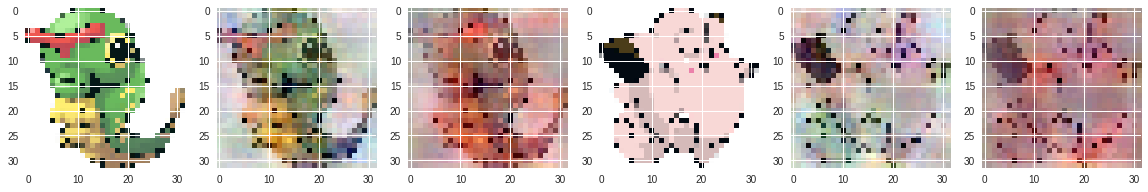

[43,    76] loss: 0.04445349 True Change 
[43,    97] loss: -1.00966720 False Change 


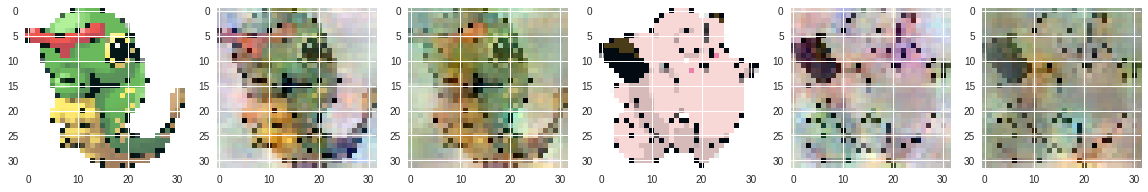

[44,    14] loss: 0.09795363 True Change 
[44,   111] loss: -1.04334468 False Change 


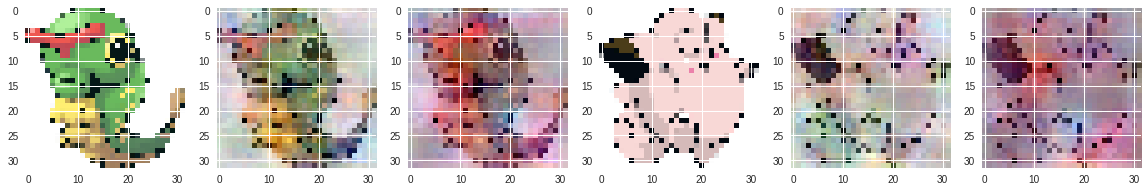

[44,   130] loss: 0.09103366 True Change 
[45,    32] loss: -1.07024462 False Change 


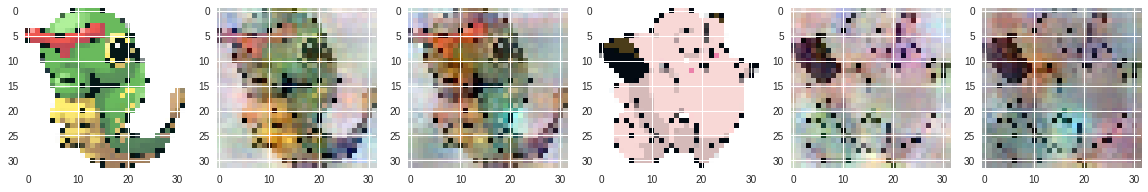

[45,    96] loss: 0.09130167 True Change 
[46,    15] loss: -1.11873913 False Change 


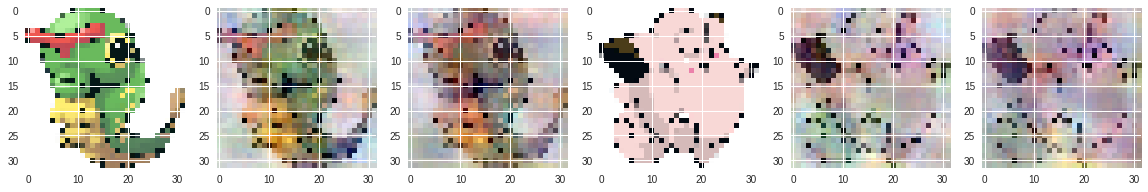

[46,   117] loss: 0.07897792 True Change 
[47,     9] loss: -1.20671591 False Change 


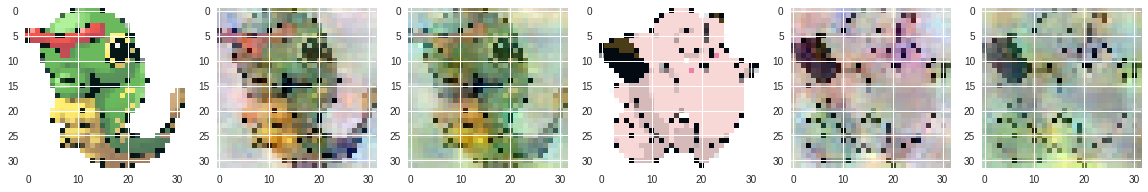

[47,    34] loss: 0.08494741 True Change 
[47,    89] loss: -1.21471991 False Change 


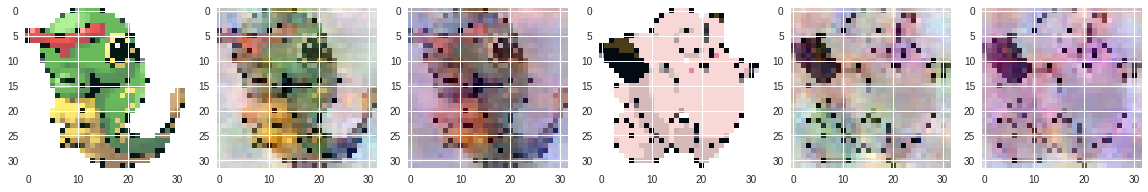

[48,     8] loss: 0.08753291 True Change 
[48,    42] loss: -1.01829012 False Change 


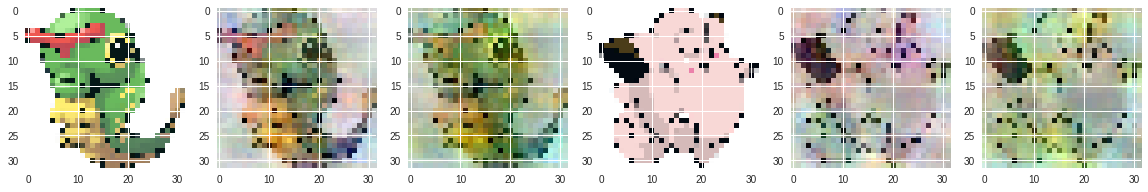

[48,    59] loss: 0.08585068 True Change 
[48,   125] loss: -1.06094257 False Change 


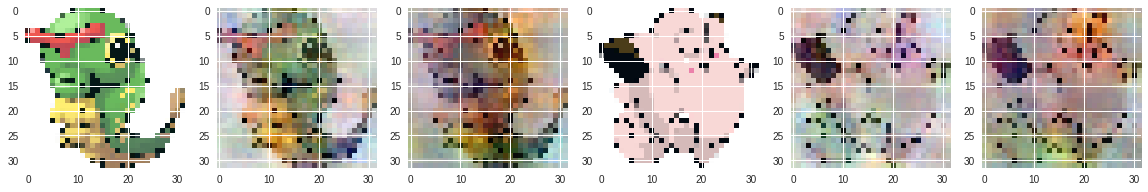

[49,    39] loss: 0.06477995 True Change 
[49,   112] loss: -1.10723289 False Change 


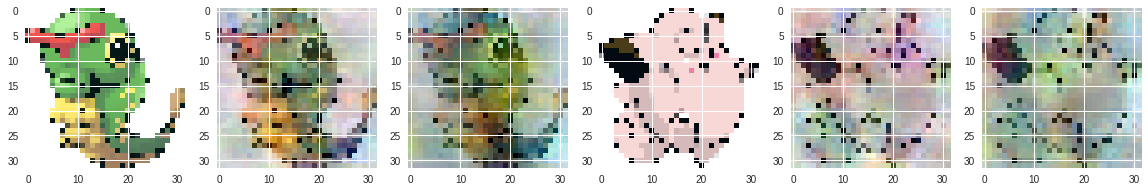

[50,    23] loss: 0.08478399 True Change 
[50,    54] loss: -1.01181615 False Change 


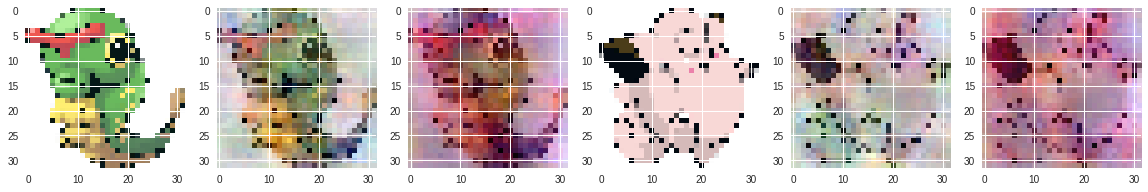

[50,    78] loss: 0.09047843 True Change 
[50,   113] loss: -1.03618459 False Change 


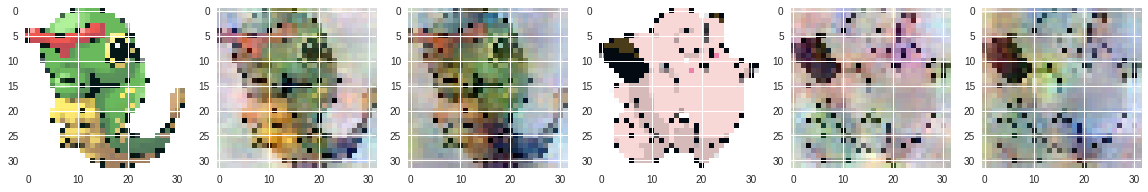

[51,    19] loss: 0.08554770 True Change 
[51,    59] loss: -1.07504585 False Change 


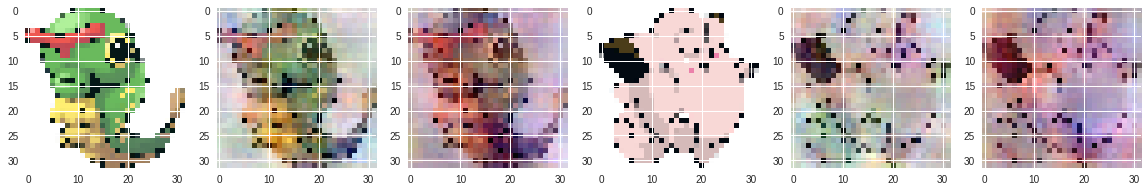

[51,    99] loss: 0.08315028 True Change 
[52,    38] loss: -1.09070269 False Change 


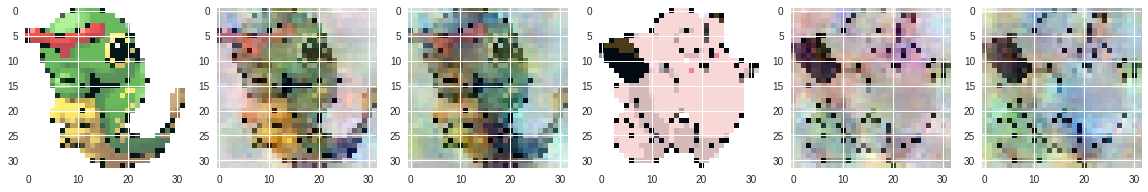

[52,   101] loss: 0.07991667 True Change 
[53,     2] loss: -1.00866292 False Change 


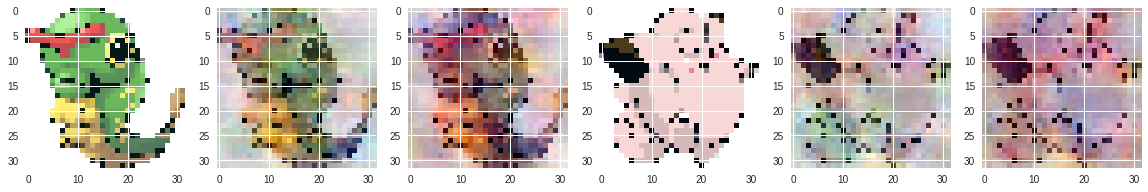

[53,    65] loss: 0.09550827 True Change 
[53,    99] loss: -1.08154276 False Change 


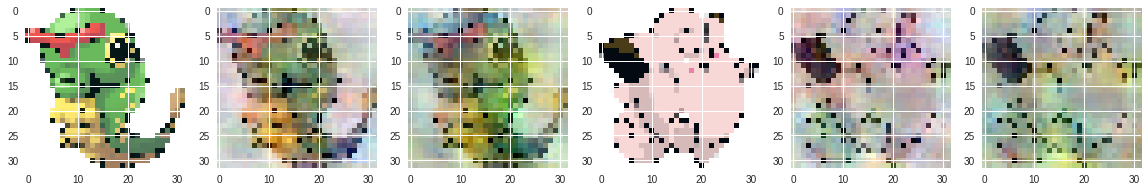

[54,     5] loss: 0.08231163 True Change 
[54,    59] loss: -1.03897906 False Change 


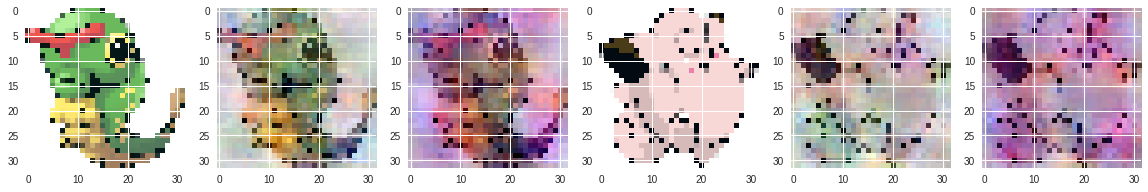

[54,    95] loss: 0.09898654 True Change 
[54,   123] loss: -1.02739988 False Change 


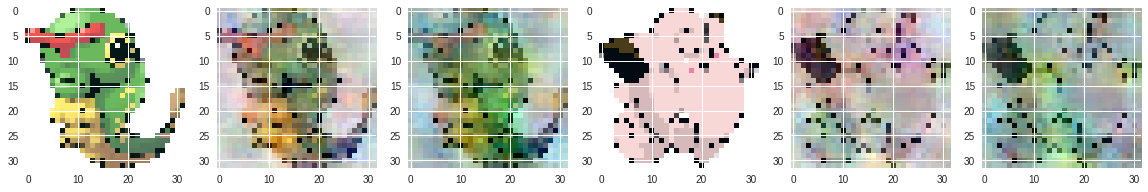

[55,    13] loss: 0.09224259 True Change 
[55,    62] loss: -1.06230390 False Change 


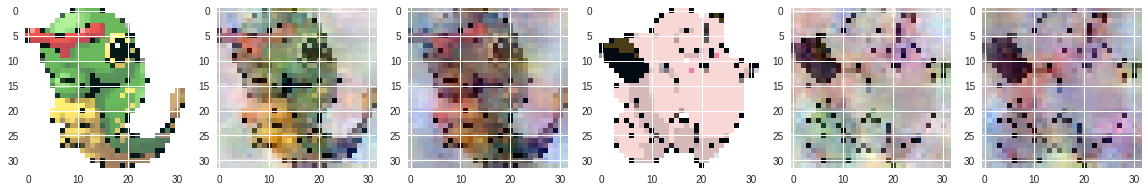

[56,     4] loss: 0.09590694 True Change 
[56,    46] loss: -1.12557330 False Change 


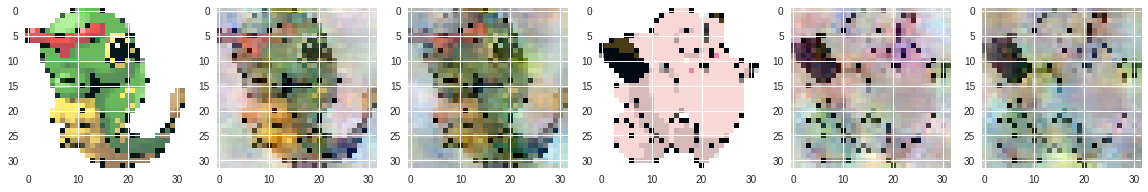

[56,    99] loss: 0.06167002 True Change 
[57,    20] loss: -1.11986803 False Change 


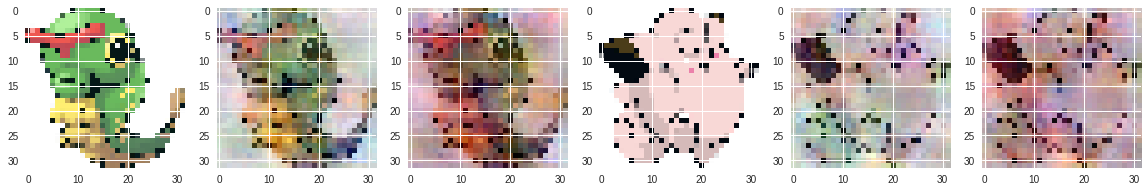

[57,    73] loss: 0.07352050 True Change 
[57,   126] loss: -1.19228543 False Change 


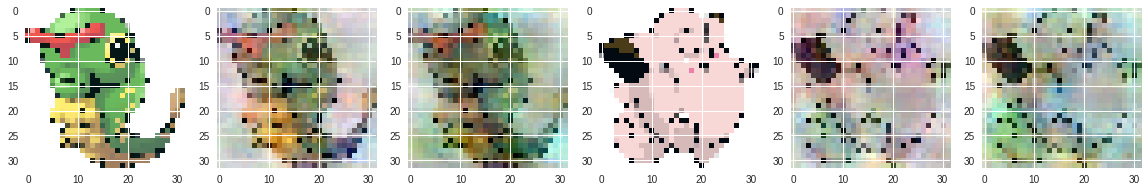

[58,     8] loss: 0.09453231 True Change 
[58,    67] loss: -1.08492294 False Change 


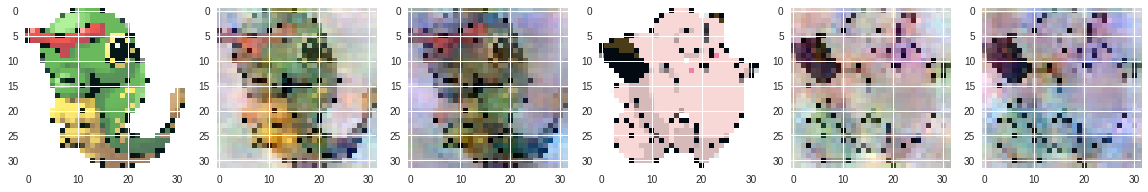

[59,    19] loss: 0.08993991 True Change 
[59,    57] loss: -1.10066191 False Change 


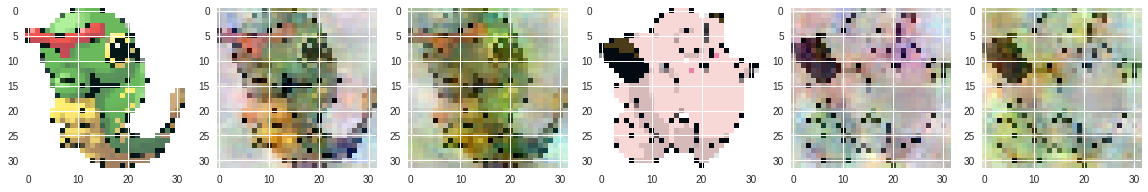

[59,    83] loss: 0.09984589 True Change 
[59,   120] loss: -1.03734016 False Change 


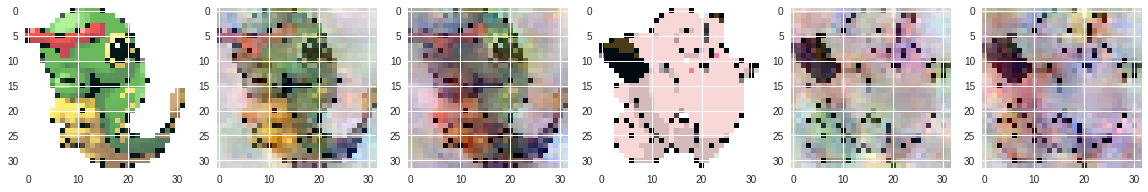

[60,    44] loss: 0.08093994 True Change 
[60,    79] loss: -1.17585492 False Change 


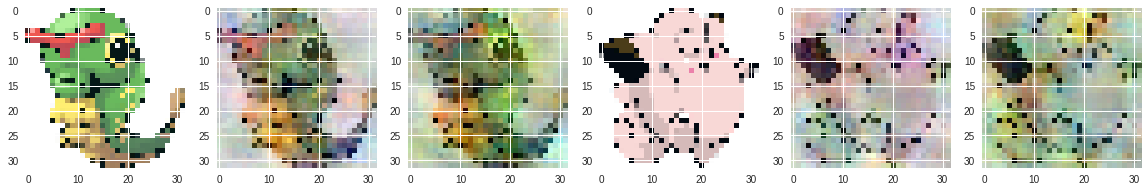

[60,   110] loss: 0.08888662 True Change 
[61,    34] loss: -1.33565579 False Change 


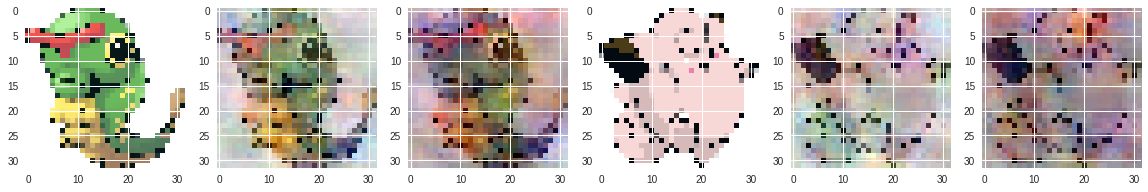

[61,    69] loss: 0.08866326 True Change 
[61,   108] loss: -1.05749878 False Change 


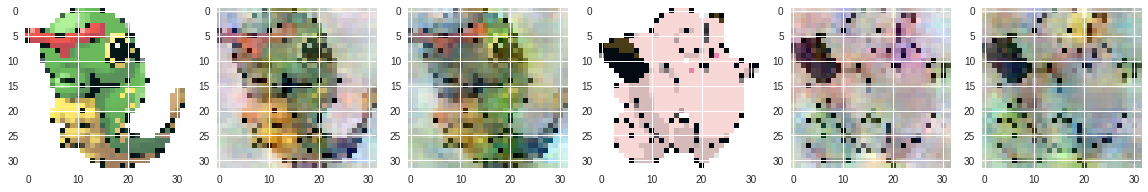

[62,    37] loss: 0.09711113 True Change 
[62,   118] loss: -1.15766506 False Change 


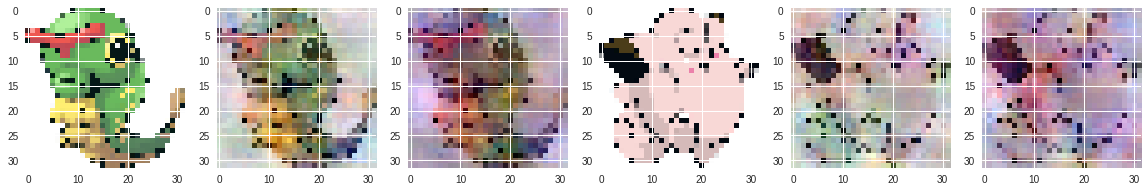

[63,    26] loss: 0.06169454 True Change 
[63,    78] loss: -1.01222519 False Change 


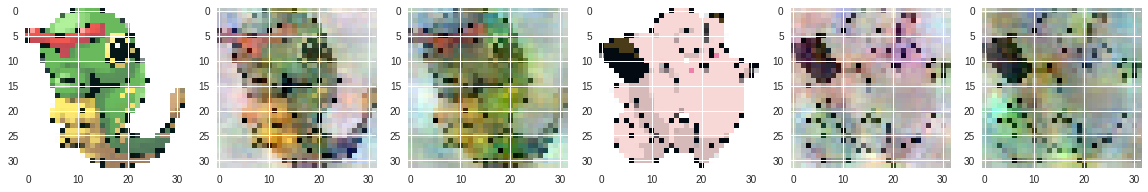

[63,   114] loss: 0.08931394 True Change 
[64,    21] loss: -1.04267311 False Change 


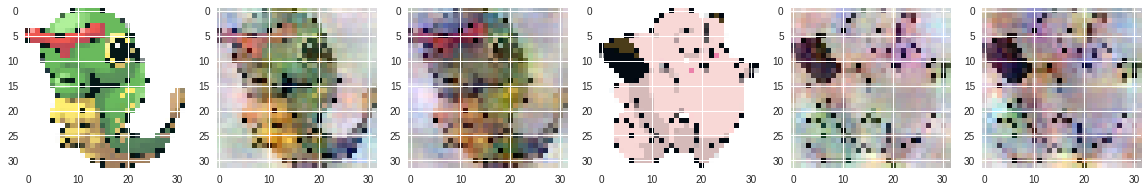

[64,    80] loss: 0.08639010 True Change 
[65,    10] loss: -1.03371831 False Change 


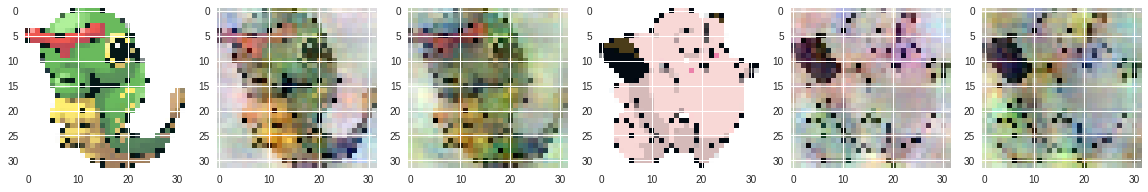

[65,    61] loss: 0.09965205 True Change 
[66,     1] loss: -1.10844689 False Change 


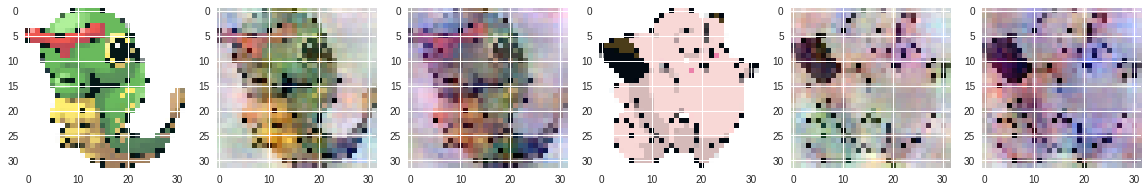

[66,    53] loss: 0.07825424 True Change 
[66,    92] loss: -1.25496655 False Change 


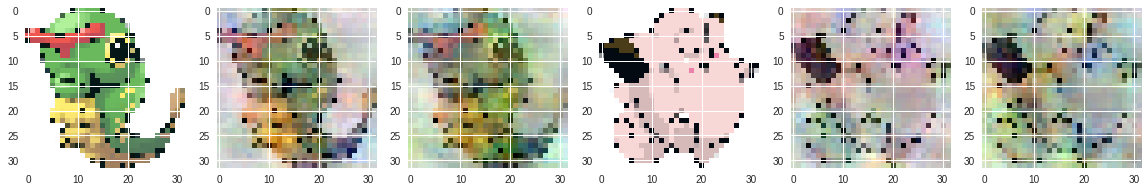

[67,    10] loss: 0.09413952 True Change 
[67,    37] loss: -1.12270352 False Change 


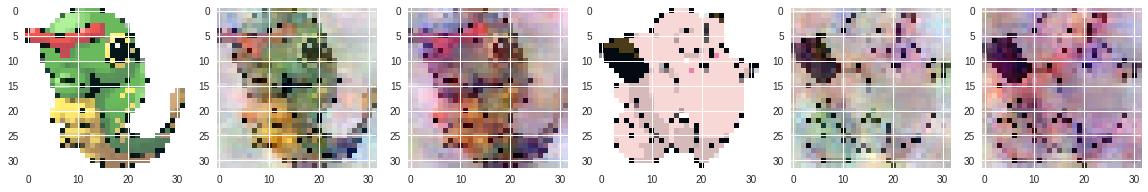

[67,    53] loss: 0.09204220 True Change 
[68,    43] loss: -1.08158915 False Change 


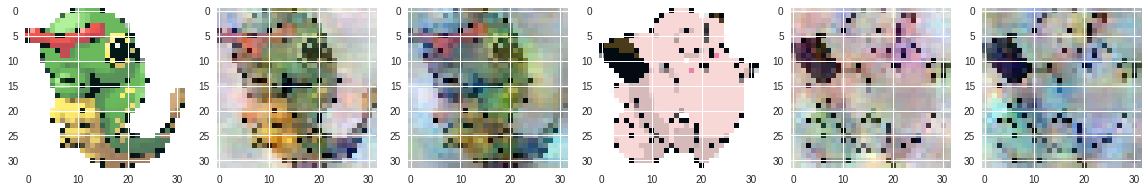

[68,    73] loss: 0.09516095 True Change 
[69,    53] loss: -1.18087088 False Change 


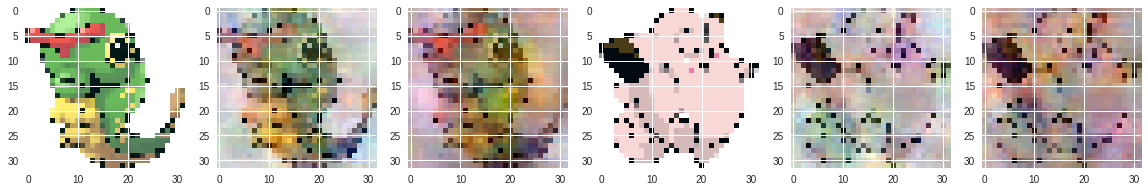

[69,   110] loss: 0.08835153 True Change 
[70,    48] loss: -1.40545572 False Change 


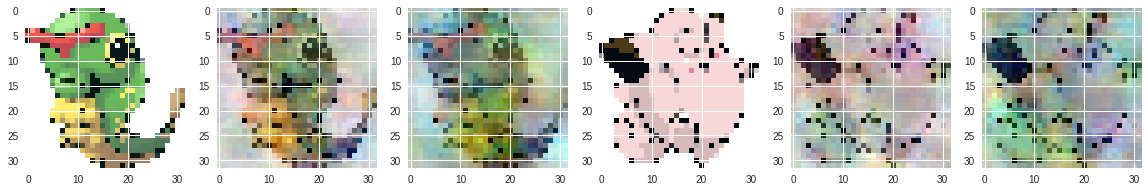

[70,    82] loss: 0.09243822 True Change 
[70,   115] loss: -1.11565085 False Change 


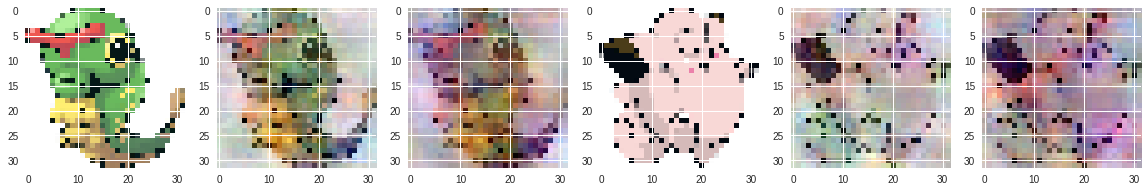

[71,    26] loss: 0.09232105 True Change 
[71,    71] loss: -1.23913668 False Change 


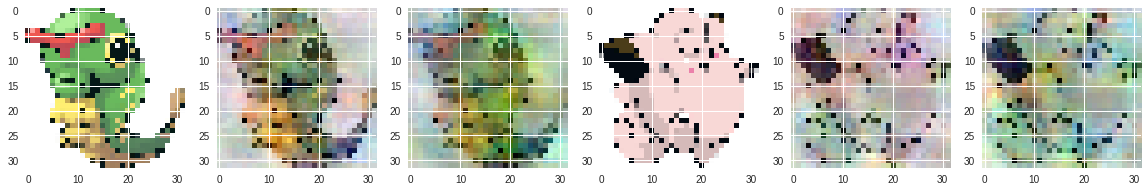

[71,    90] loss: 0.09974424 True Change 
[72,     3] loss: -1.05232327 False Change 


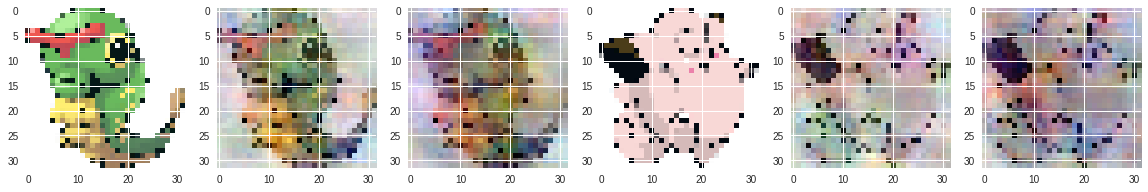

[72,   116] loss: 0.09709331 True Change 
[73,    48] loss: -1.17481967 False Change 


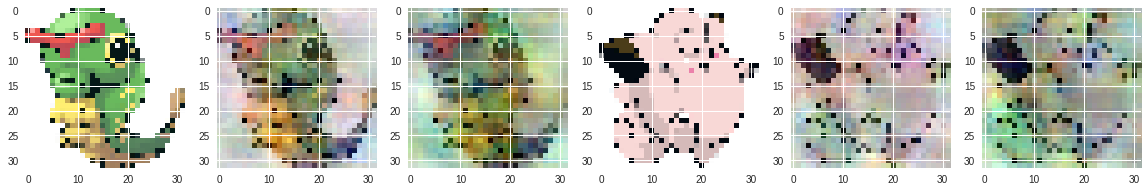

[73,    63] loss: 0.07894381 True Change 
[73,   129] loss: -1.00423540 False Change 


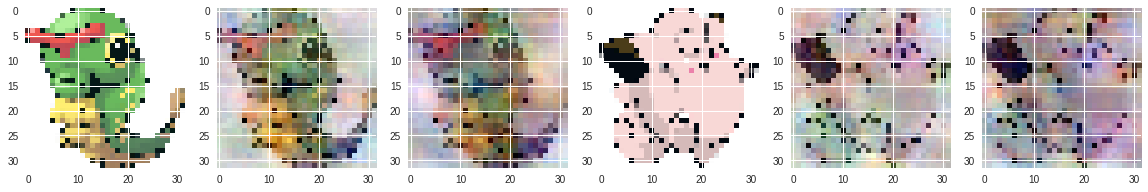

[74,    30] loss: 0.09973761 True Change 
[74,    82] loss: -1.07086828 False Change 


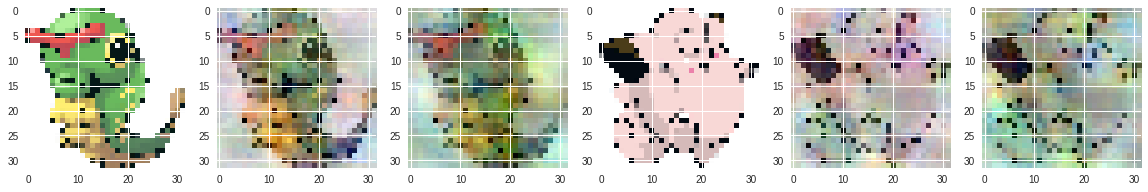

[74,   115] loss: 0.08318335 True Change 
[75,    25] loss: -1.02047587 False Change 


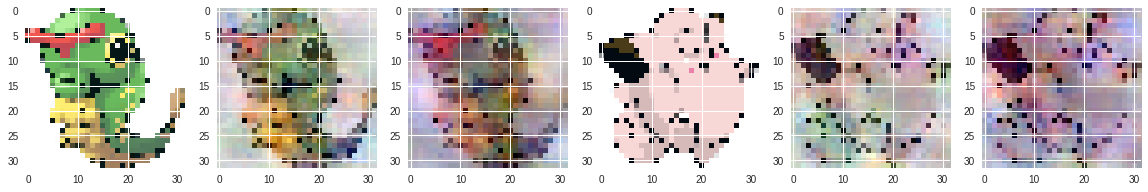

[75,    67] loss: 0.09780363 True Change 
[75,   105] loss: -1.02928732 False Change 


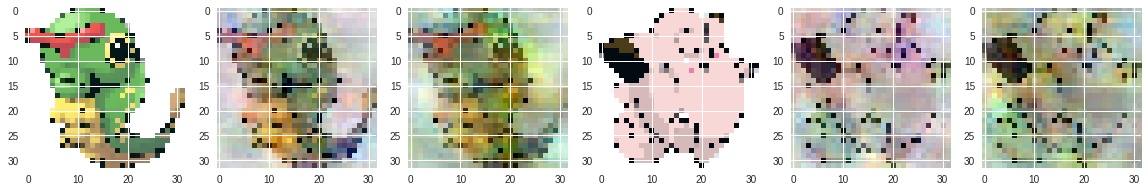

[76,    10] loss: 0.07521965 True Change 
[76,    86] loss: -1.06670896 False Change 


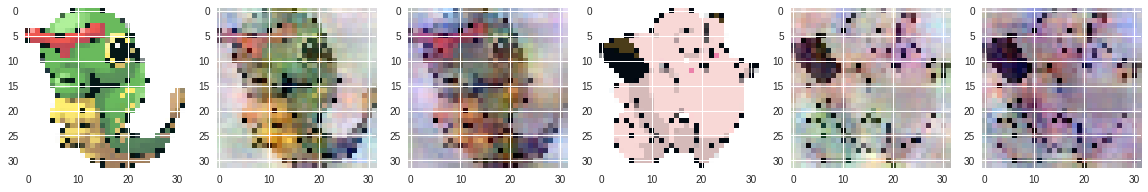

[77,    14] loss: 0.09874006 True Change 
[77,    76] loss: -1.12355777 False Change 


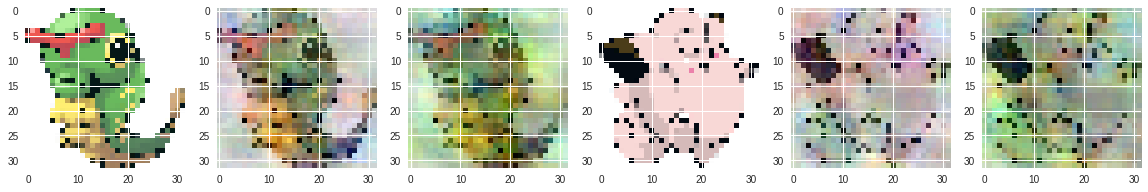

[77,    98] loss: 0.05838434 True Change 
[78,    21] loss: -1.01948388 False Change 


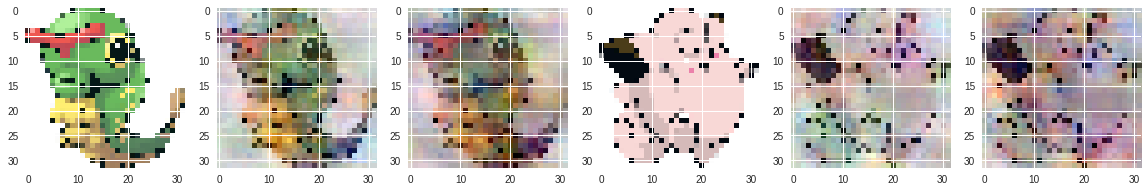

[78,    98] loss: 0.08759319 True Change 
[79,    17] loss: -1.04768927 False Change 


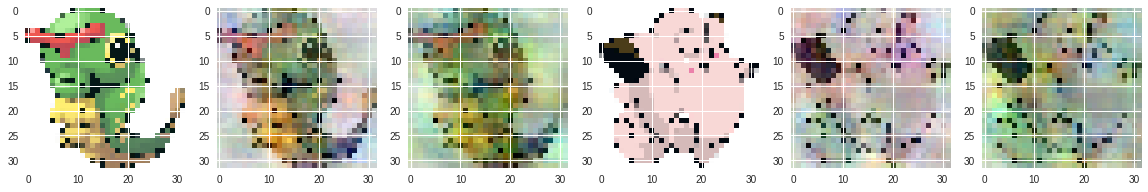

[79,    43] loss: 0.09422723 True Change 
[79,    99] loss: -1.05377369 False Change 


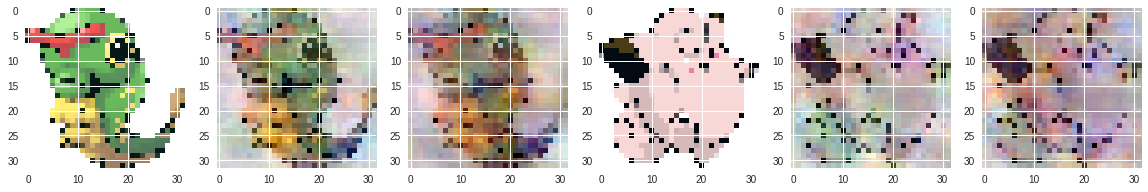

[80,     4] loss: 0.08811073 True Change 
[80,    73] loss: -1.06055089 False Change 


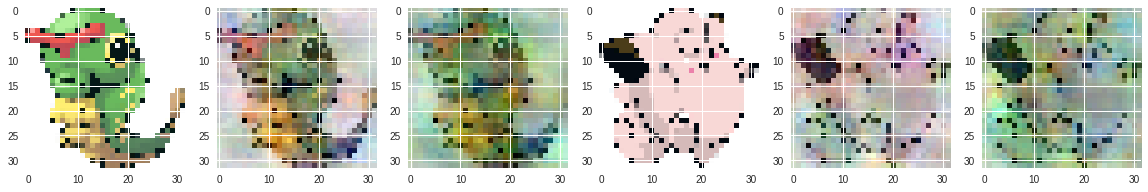

[80,   100] loss: 0.08057750 True Change 
[81,    77] loss: -1.25864328 False Change 


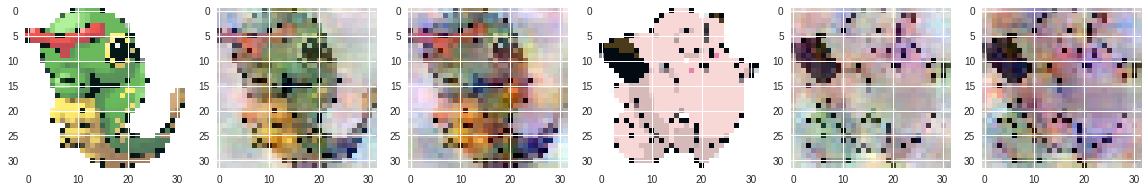

[82,    20] loss: 0.08004810 True Change 
[82,    55] loss: -1.01931282 False Change 


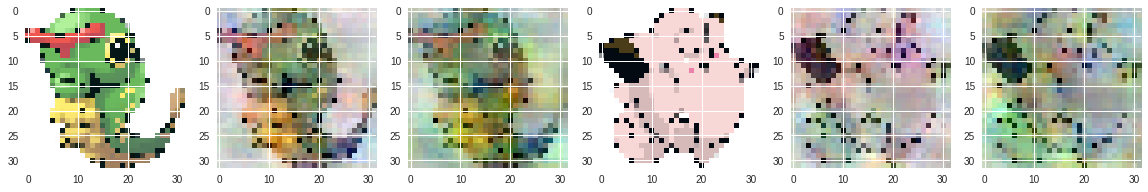

[82,   104] loss: 0.07744716 True Change 
[83,     1] loss: -1.03103802 False Change 


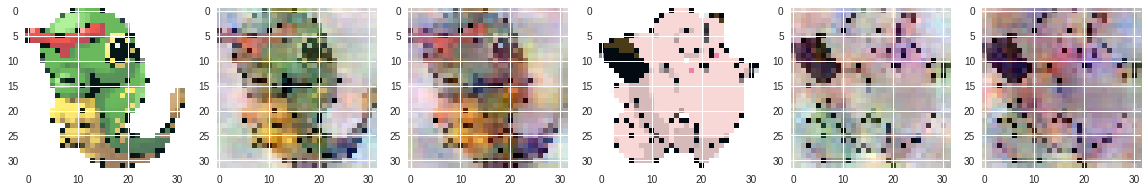

[83,    25] loss: 0.06933042 True Change 
[84,     6] loss: -1.23930249 False Change 


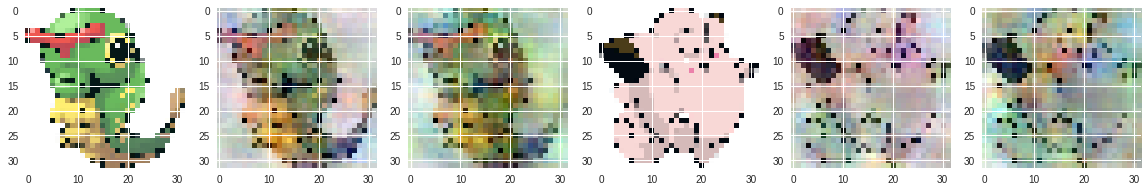

[84,    45] loss: 0.09712758 True Change 
[84,   106] loss: -1.09994176 False Change 


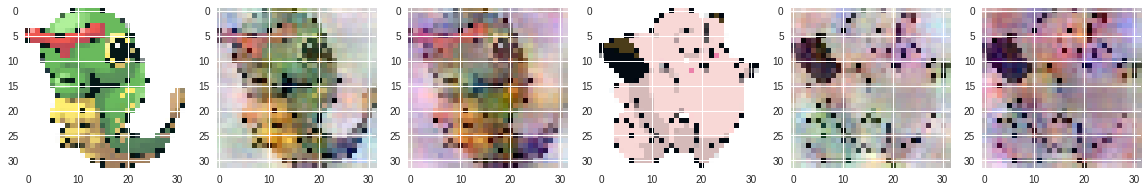

[85,    11] loss: 0.04983298 True Change 
[85,    97] loss: -1.11769707 False Change 


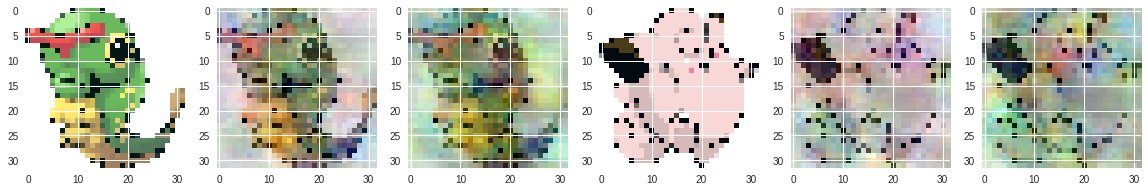

[86,     3] loss: 0.08878867 True Change 
[86,    43] loss: -1.09130906 False Change 


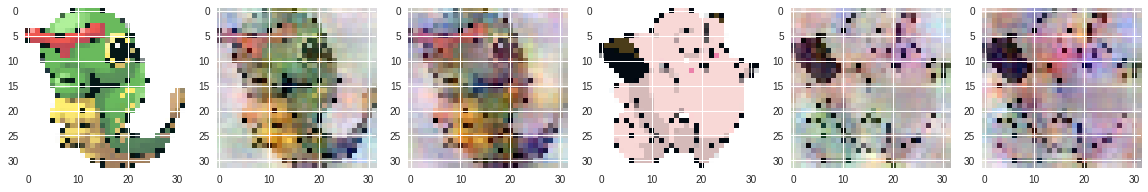

[86,    90] loss: 0.09852487 True Change 
[87,    46] loss: -1.03711270 False Change 


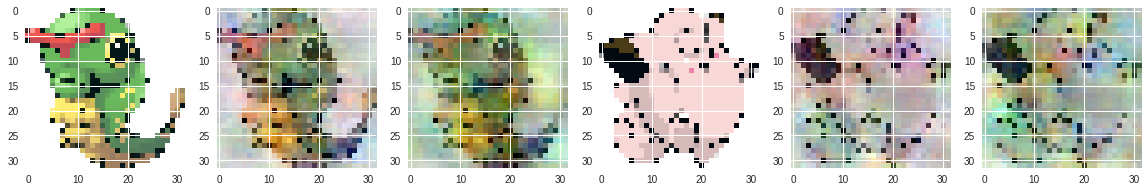

[87,    79] loss: 0.09936923 True Change 
[87,   125] loss: -1.00370277 False Change 


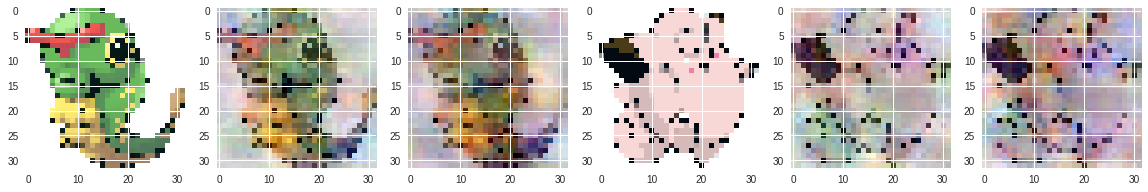

[88,    46] loss: 0.09797514 True Change 
[89,    49] loss: -1.07919737 False Change 


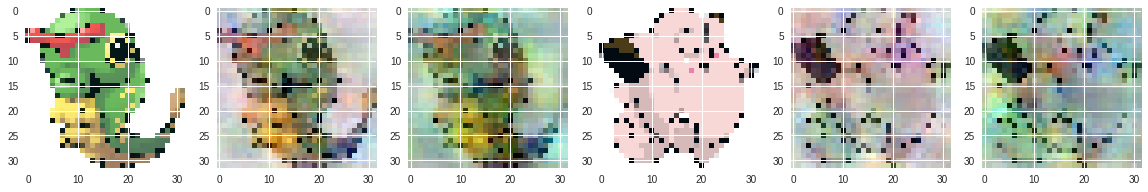

[89,    87] loss: 0.09704898 True Change 
[89,   124] loss: -1.06131485 False Change 


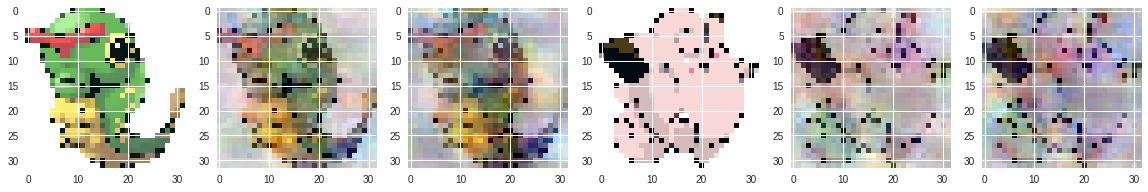

[90,    83] loss: 0.09383447 True Change 
[91,    35] loss: -1.06365785 False Change 


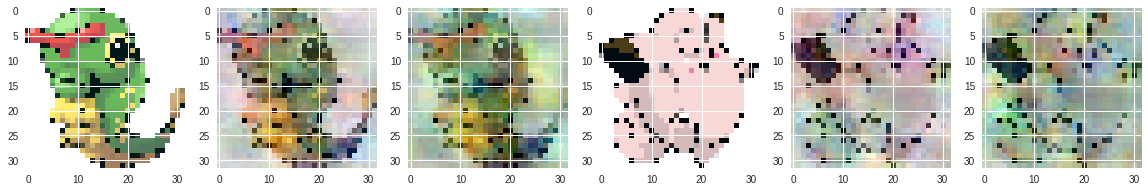

[91,    74] loss: 0.07889608 True Change 
[92,     9] loss: -1.03866868 False Change 


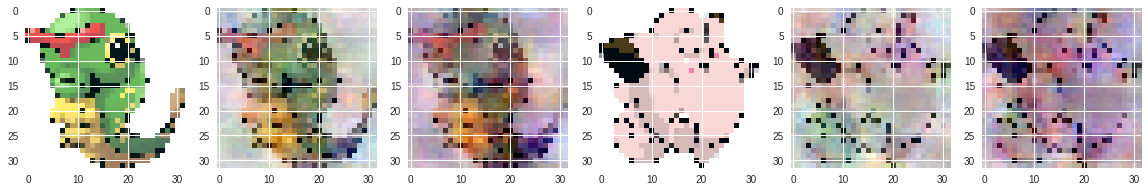

[92,    50] loss: 0.07880363 True Change 
[93,    42] loss: -1.33800240 False Change 


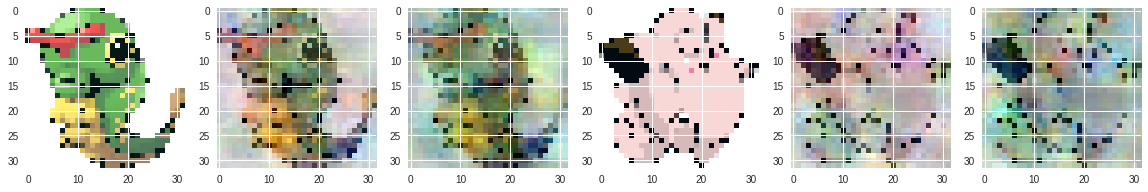

[93,    81] loss: 0.09093010 True Change 
[94,    17] loss: -1.23432190 False Change 


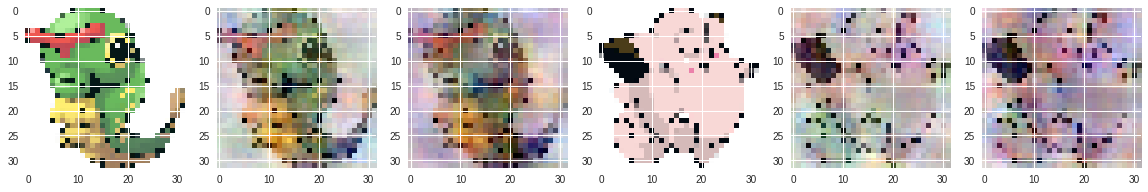

[94,    43] loss: 0.09242470 True Change 
[94,   108] loss: -1.25017303 False Change 


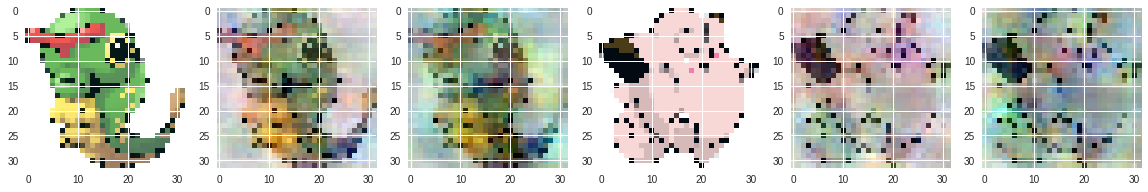

[95,    62] loss: 0.08896271 True Change 
[95,    94] loss: -1.02253985 False Change 


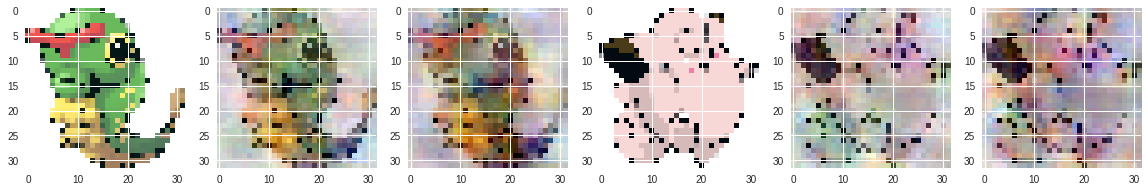

[96,    22] loss: 0.09447624 True Change 
[96,   103] loss: -1.14280178 False Change 


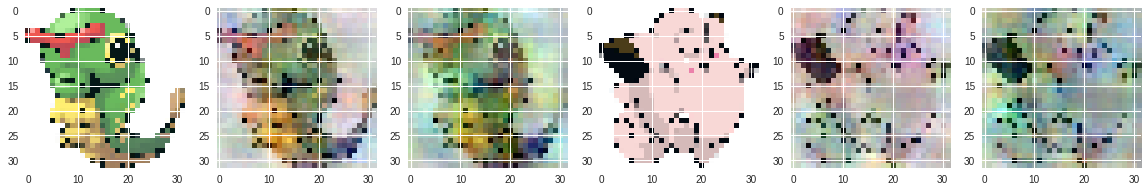

[97,     4] loss: 0.09758201 True Change 
[97,    58] loss: -1.03895257 False Change 


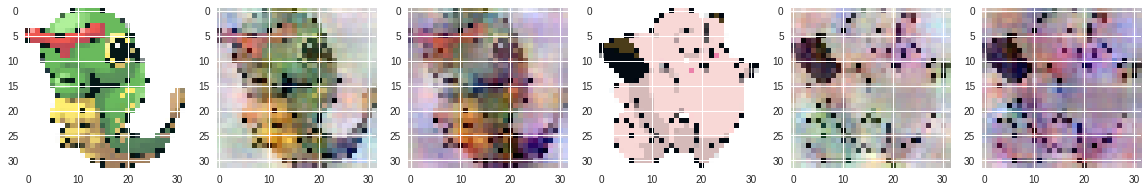

[97,    87] loss: 0.07880807 True Change 
[98,    49] loss: -1.07081626 False Change 


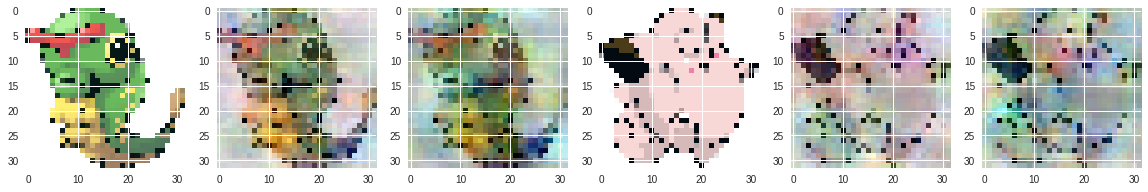

[98,   106] loss: 0.07717156 True Change 
[99,    61] loss: -1.15793878 False Change 


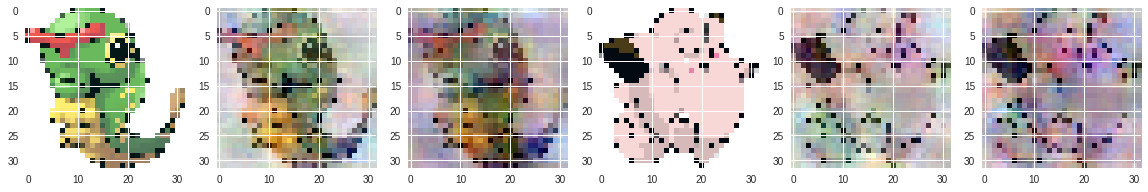

[99,    90] loss: 0.08470749 True Change 
[100,    24] loss: -1.15016763 False Change 


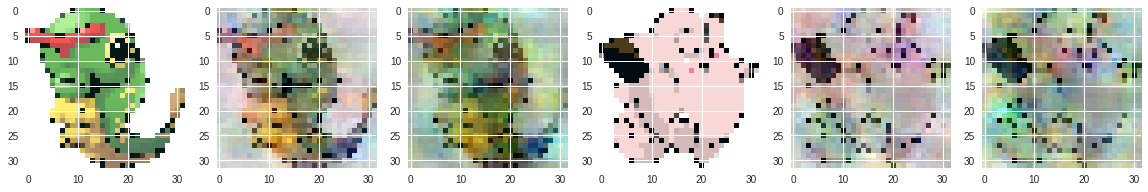

[100,    52] loss: 0.07658462 True Change 
[100,   129] loss: -1.10528990 False Change 


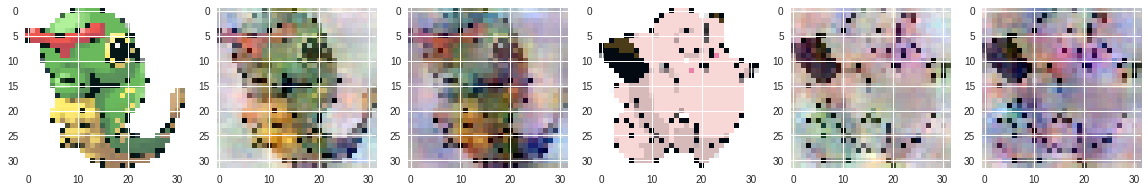

[101,    34] loss: 0.09777085 True Change 
[102,    23] loss: -1.09340165 False Change 


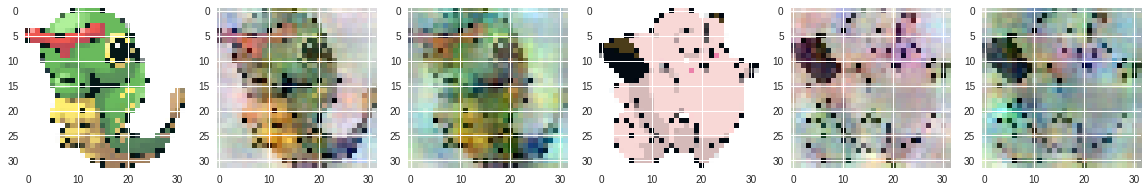

[102,    67] loss: 0.09639644 True Change 
[103,    13] loss: -1.02554645 False Change 


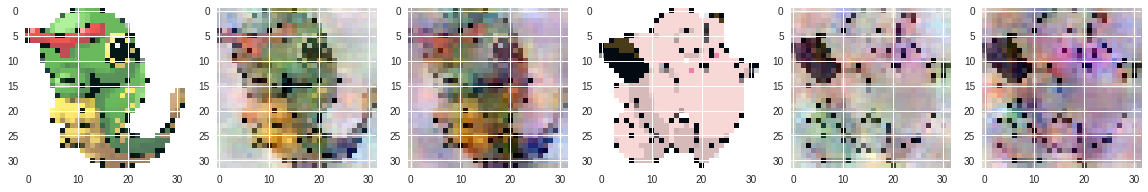

[103,    68] loss: 0.07524183 True Change 
[103,   130] loss: -1.10337950 False Change 


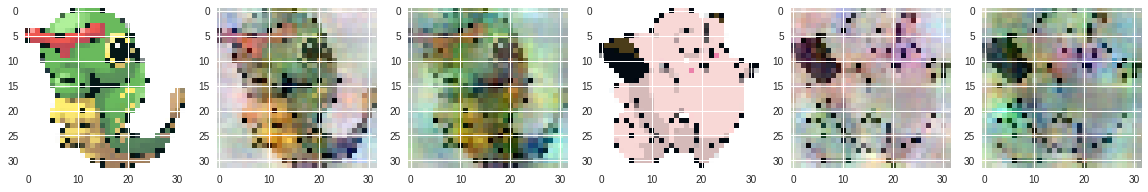

[104,    32] loss: 0.07291544 True Change 
[104,    93] loss: -1.16899055 False Change 


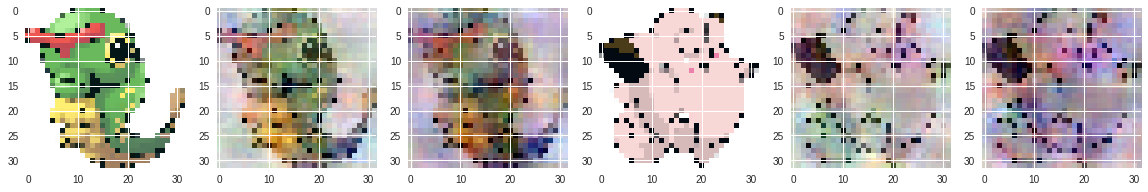

[104,   134] loss: 0.08810149 True Change 
[105,   119] loss: -1.05258619 False Change 


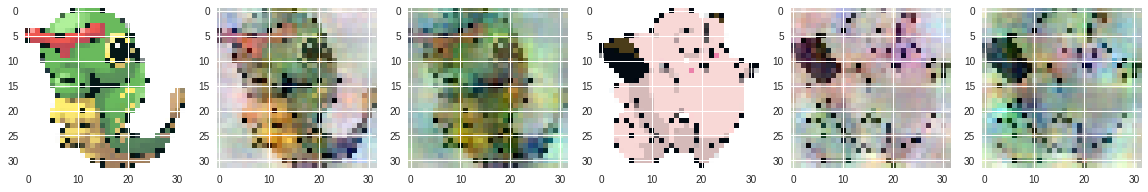

[106,    26] loss: 0.07267654 True Change 
[106,    65] loss: -1.15215450 False Change 


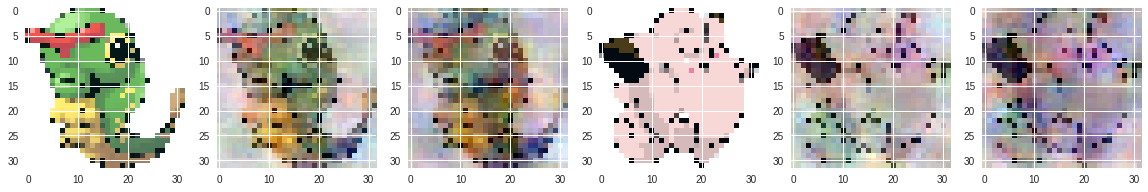

[106,    96] loss: 0.09627490 True Change 
[107,     2] loss: -1.02625044 False Change 


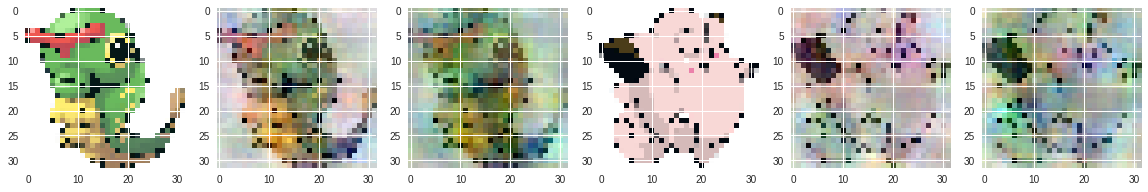

[107,    43] loss: 0.08496838 True Change 
[108,     8] loss: -1.13133997 False Change 


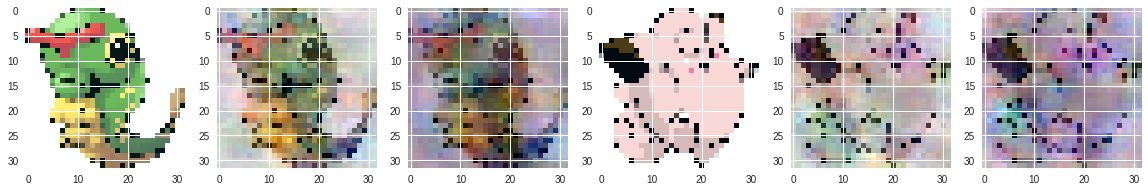

[108,    36] loss: 0.08402551 True Change 
[109,    94] loss: -1.06021649 False Change 


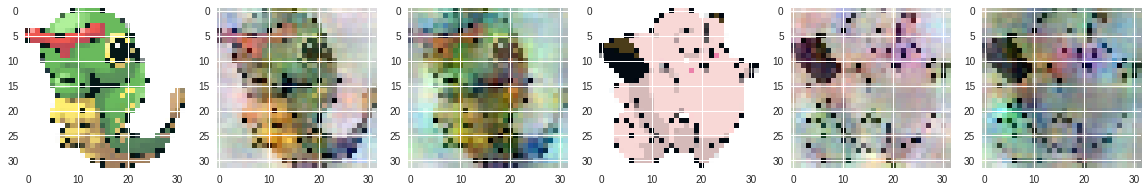

[110,    25] loss: 0.08888057 True Change 
[110,    79] loss: -1.06790830 False Change 


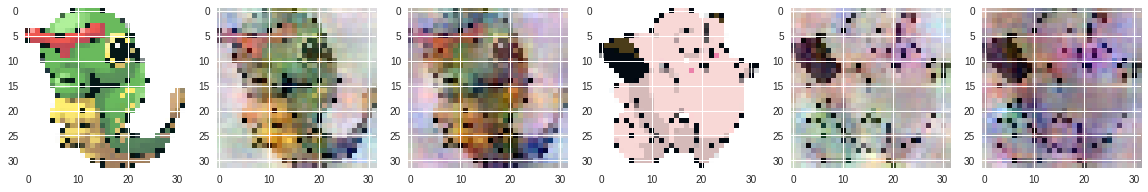

[110,   109] loss: 0.09993797 True Change 
[111,    77] loss: -1.02044398 False Change 


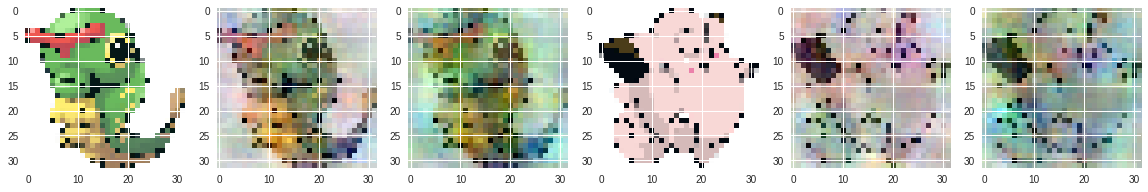

[111,   123] loss: 0.06785021 True Change 
[112,    33] loss: -1.08208987 False Change 


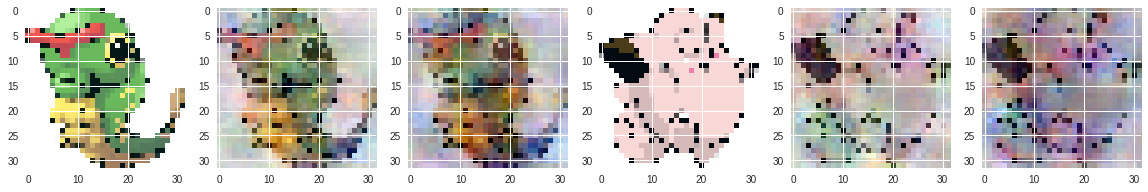

[112,   101] loss: 0.07448308 True Change 
[113,   115] loss: -1.08183233 False Change 


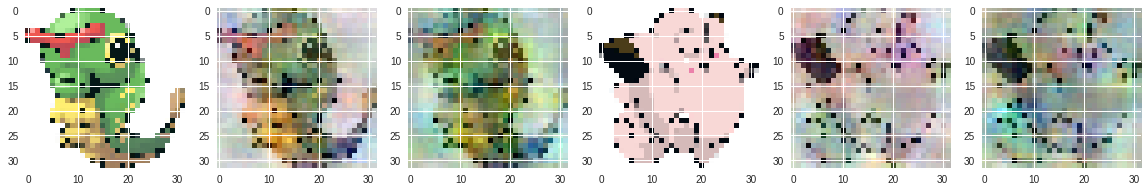

[114,     3] loss: 0.05856500 True Change 
[115,    28] loss: -1.04655666 False Change 


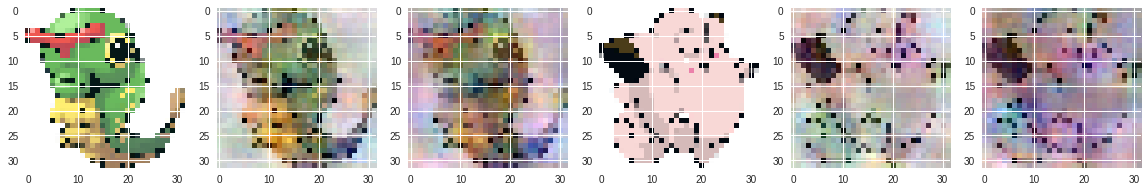

[115,    62] loss: 0.09731463 True Change 
[117,    74] loss: -1.01210747 False Change 


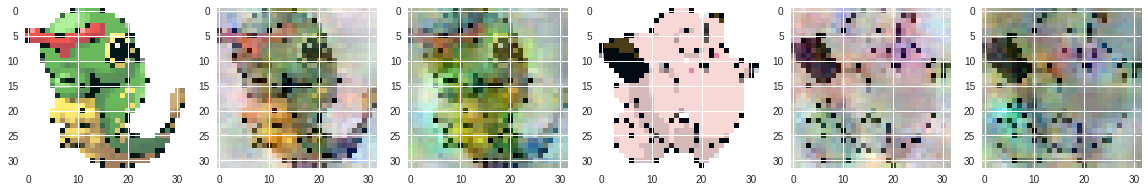

[117,   128] loss: 0.09448038 True Change 
[118,    49] loss: -1.05311688 False Change 


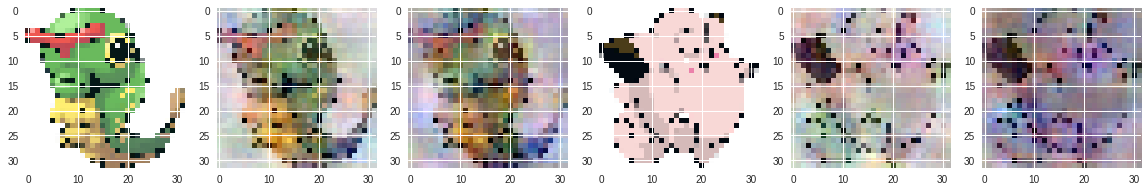

[118,   119] loss: 0.09672042 True Change 
[119,    22] loss: -1.11541133 False Change 


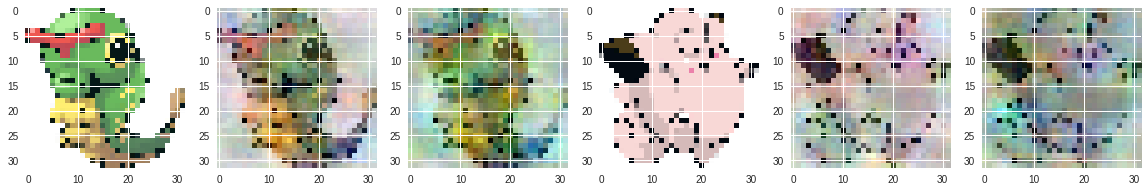

[119,    77] loss: 0.05481683 True Change 
[120,    32] loss: -1.04392263 False Change 


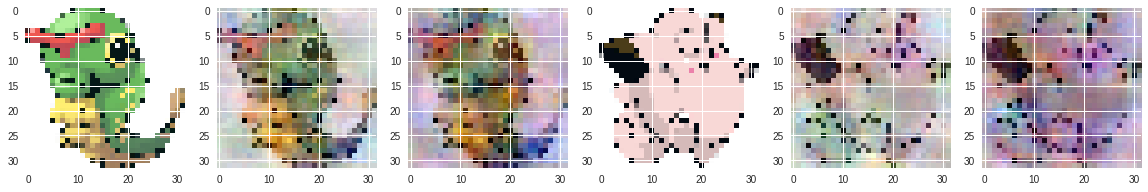

[120,    63] loss: 0.09803362 True Change 
[120,   129] loss: -1.04416566 False Change 


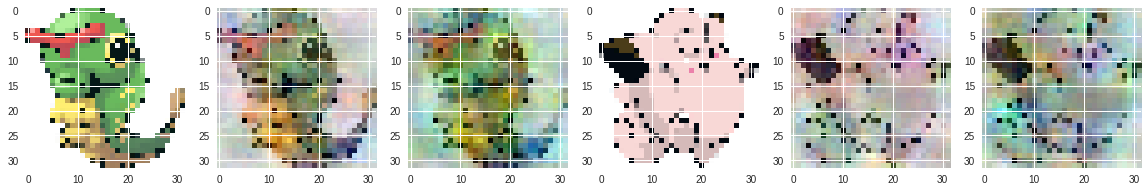

[121,    36] loss: 0.08909678 True Change 
[121,   115] loss: -1.16145794 False Change 


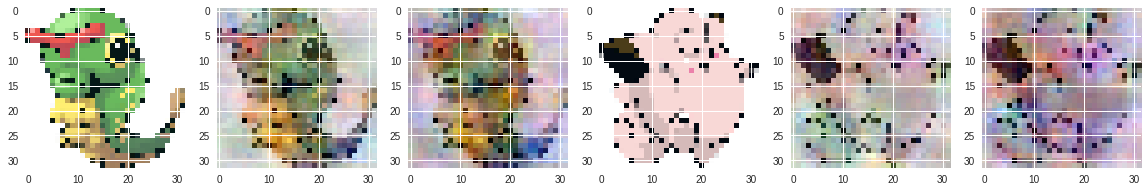

[122,    36] loss: 0.08328989 True Change 
[122,    83] loss: -1.00953357 False Change 


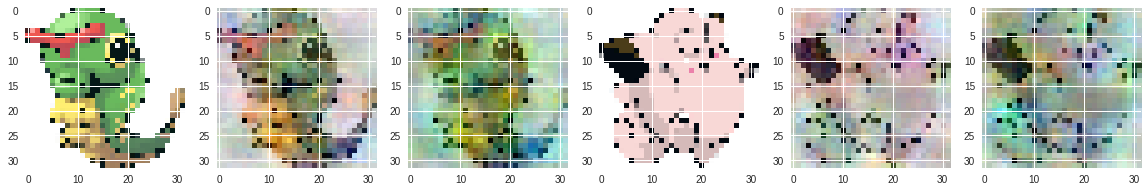

[122,   114] loss: 0.09706796 True Change 
[123,    24] loss: -0.66776490 False

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



[123,    26] loss: -0.64807430 FalseTraceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 482, in getmodu

IndexError: ignored

In [0]:

des = True
losses = []
for epoch in range(T): 
    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
        labels = xtrain_target[idxsmp]
        # Initialize the gradients to zero 
        voutputs = net.auto_encode_forward(xval[:10])
#         vloss = criterion(voutputs[:10] , xval[:10])
        optimizer.zero_grad()

        # Forward propagation 
        outputs = net.auto_encode_forward(inputs)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)

        sel = ag.Variable((torch.ByteTensor(B).random_()<128).double().cuda(), requires_grad=False)
#         print(inputs.size(), sel.size())
#         print(sel)

        inp = inputs * sel.view(B, 1, 1, 1) + outputs * (1-sel.view(B, 1, 1, 1))
#         plt.imshow(inp[0].cpu().data.numpy().transpose([1, 2, 0]))
#         plt.show()
        
#         plt.imshow(inp[4].cpu().data.numpy().transpose([1, 2, 0]))
#         plt.show()
        
#         print(sel)
#         break
        out = net.discriminate(inp)
        loss = criterion(out[:,1] , sel)

        

        if not des:
            loss = -loss
        else:
            losses.append((loss[0].cpu().data.numpy()))
        # Back propagation 
        loss.backward()
        

        # Parameter update 
        if des:
            discriminator_optimizer.step()
        else:
            generator_optimizer.step()
        
#         des = not des

        # Print averaged loss per minibatch every 100 mini-batches
        if des:
            losses.append(loss[0].cpu().data.numpy())
        else:
            losses.append(-loss[0].cpu().data.numpy())

        
            
#         print(k)
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f %s' % (epoch + 1, k + 1, loss[0].cpu().data.numpy(), des), end="")
            running_loss = 0.0
            
        if des and (loss[0].cpu().data.numpy() < 0.1):
            print(" Change ")
            des = not des
        if not des and (loss[0].cpu().data.numpy() < -1):
            print(" Change ")
            des = not des
            fig, axes = plt.subplots(1, 6, figsize=(20,6))
            axes[0].imshow(convert(xval[3].cpu().data.numpy().transpose([1, 2, 0])))
            axes[1].imshow(convert(storedv[3].cpu().data.numpy().transpose([1, 2, 0])))
            axes[2].imshow(convert(voutputs[3].cpu().data.numpy().transpose([1, 2, 0])))
            axes[3].imshow(convert(xval[5].cpu().data.numpy().transpose([1, 2, 0])))
            axes[4].imshow(convert(storedv[5].cpu().data.numpy().transpose([1, 2, 0])))
            axes[5].imshow(convert(voutputs[5].cpu().data.numpy().transpose([1, 2, 0])))
            plt.show()
#     break 
#     plt.imshow(outputs[0].cpu().data.numpy().transpose([1, 2, 0]))
#     plt.show()

print ( ' Finished Training ' )


In [0]:
net.load_state_dict(torch.load('auto_gan3.net'))


In [0]:
codes, _, _ = net.encode(xtrain[:100])
codes = codes.cpu().data.numpy()
# print(codes.shape, codes.mean(axis=0), codes.std(axis=0))

m = codes.mean(axis=0)
s = codes.std(axis=0)

(100, 64) [ 3.8178212   5.52943312  3.86556588  7.30818213  3.74126525  0.40739692
  3.43959476 -0.21825263 -0.49298393  0.73905184  4.91246747 -1.14188736
 -0.54213956  5.23610386 10.06244026  7.39002203  4.60063103  3.72402409
 -1.14811899  6.67222454  5.93587626  6.66551508  6.73851577  3.54433989
 -0.56992748 10.67436921  4.32956892 -0.53811166  5.33000678  5.93148698
 -0.48813097  8.330569    8.17750005 -0.55880609 -0.34243567  0.5191874
  8.23279257 -0.6010747   6.05410773  7.71487058  7.37037732  8.189133
  3.88079837  1.08496686  3.66385171  3.21801256 -0.02100915  3.21811513
  4.92618478  5.34122774  9.08880296  4.52014887  6.54700212  0.42640091
  3.20502887  4.15897699  6.12057199 -0.50404328  2.03854375 -0.42507159
 -0.58904808  3.65760994  6.09408155  9.74251367] [3.35854115 3.2874929  2.39749988 3.72926185 3.01737463 1.25011765
 2.53668122 1.09547829 0.25955223 2.09449067 3.40326221 0.36568386
 0.23330747 3.09205065 6.76222732 3.7363808  2.98712449 2.10130243
 0.27768415 

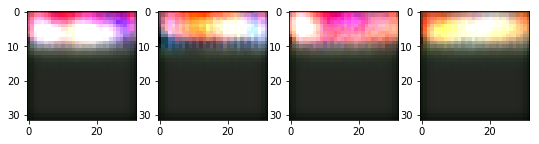

In [0]:
# rand = ag.Variable(torch.normal(5, 5*torch.ones((B, 64))).double().cuda(), requires_grad=True)
rand = ag.Variable(torch.normal(m*torch.ones((B, 64))*0.5, s*torch.ones((B, 64))).double().cuda(), requires_grad=True)

fig, axes = plt.subplots(1, 4, figsize=(9,6))
gens = net.generator(rand)
for i in range(4):
    axes[i].imshow(convert(gens[i].cpu().data.numpy().transpose([1, 2, 0])))
plt.show()

In [0]:
import math
N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 1000
# T = 1
gamma = .001
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=gamma , momentum=rho)
dec_optimizer = torch.optim.Adam(net.parameters(), lr=gamma)
DECO = [net.fc3r, net.fc2r,net.fc1r, net.conv2r, net.conv1r, net.conv3r, net.conv4r]
DECO = reduce(lambda x, y: x+y, list(map(lambda x: [p for p in x.parameters()], DECO)), [])
# print(len(DECO))
generator_optimizer = torch.optim.Adam(DECO, lr=0.00001)

DESC = [net.descriminator_conv1, net.descriminator_conv2, net.descriminator] 
DESC = reduce(lambda x, y: x+y, list(map(lambda x: [p for p in x.parameters()], DESC)), [])
discriminator_optimizer = torch.optim.Adam(DESC, lr=0.0001)

[1,     7] loss: 0.00171737 True Change 
[2,    46] loss: -2.40335702 False Change 


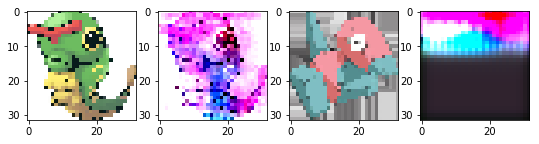

[2,    59] loss: 0.02149527 True Change 
[21,   129] loss: -0.03869417 False

KeyboardInterrupt: 

In [0]:

des = True
losses = []
for epoch in range(T): 
    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
#         labels = xtrain_target[idxsmp]
        # Initialize the gradients to zero 
        voutputs = net.auto_encode_forward(xval[:10])
# #         codes, _, _ = net.encode(xval[:10])
# #         codes = codes.cpu().data.numpy()
#         print(codes.shape, codes.mean(axis=1), codes.std(axis=1))
#         vloss = criterion(voutputs[:10] , xval[:10])
        optimizer.zero_grad()

#         v, _, _ = net.encode(inputs)
#         print(v.size())
        # Forward propagation 
        rand = ag.Variable(torch.normal(5, 5*torch.ones((B, 64))).double().cuda(), requires_grad=True)
        outputs = net.generator(rand)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)

        sel = ag.Variable((torch.ByteTensor(B).random_()<128).double().cuda(), requires_grad=False)
#         print(inputs.size(), sel.size())
#         print(sel)

        inp = inputs * sel.view(B, 1, 1, 1) + outputs * (1-sel.view(B, 1, 1, 1))
#         plt.imshow(inp[0].cpu().data.numpy().transpose([1, 2, 0]))
#         plt.show()
        
#         plt.imshow(inp[4].cpu().data.numpy().transpose([1, 2, 0]))
#         plt.show()
        
#         print(sel)
#         break
        out = net.discriminate(inp)
        loss = criterion(out[:,1] , sel)

        

        if not des:
            loss = -loss
        else:
            losses.append((loss[0].cpu().data.numpy()[0]))
        # Back propagation 
        loss.backward()
        

        # Parameter update 
        if des:
            discriminator_optimizer.step()
        else:
            generator_optimizer.step()
        
#         des = not des

        # Print averaged loss per minibatch every 100 mini-batches
        if des:
            losses.append(loss[0].cpu().data.numpy()[0])
        else:
            losses.append(-loss[0].cpu().data.numpy()[0])

        
            
#         print(k)
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f %s' % (epoch + 1, k + 1, loss[0].cpu().data.numpy()[0], des), end="")
            running_loss = 0.0
            
        if des and (loss[0].cpu().data.numpy()[0] < 0.03):
            print(" Change ")
            des = not des
        if not des and (loss[0].cpu().data.numpy()[0] < -2):
            print(" Change ")
            des = not des
            fig, axes = plt.subplots(1, 4, figsize=(9,6))
            axes[0].imshow(convert(xval[3].cpu().data.numpy().transpose([1, 2, 0])))
            axes[1].imshow(convert(voutputs[3].cpu().data.numpy().transpose([1, 2, 0])))
            axes[2].imshow(convert(inputs[5].cpu().data.numpy().transpose([1, 2, 0])))
            axes[3].imshow(convert(outputs[5].cpu().data.numpy().transpose([1, 2, 0])))
            plt.show()
#     break 
#     plt.imshow(outputs[0].cpu().data.numpy().transpose([1, 2, 0]))
#     plt.show()

print ( ' Finished Training ' )


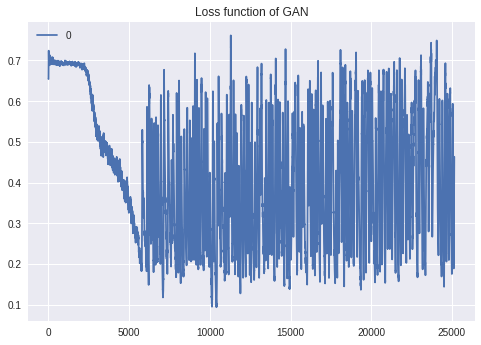

In [0]:
pd.DataFrame(losses[:]).ewm(20).mean().plot(title="Loss function of GAN")
# torch.save(net.state_dict(), 'auto_gan2.net')
# criterion(ag.Variable(torch.ones(B),requires_grad=True), ag.Variable(torch.zeros(B), requires_grad=False))

Train Classifier

In [0]:
net.load_state_dict(torch.load('class3.net'))

In [0]:
for param in net.parameters():
    param.requires_grad = True
for param in net.classifier.parameters():
    param.requires_grad = True

In [0]:
losses = []

In [0]:
import math

N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 1000
# T = 1
gamma = .001
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.SGD(net.classifier.parameters(), lr=gamma , momentum=rho)
optimizer = torch.optim.Adam(net.classifier.parameters(), lr=gamma)
# optimizer = torch.optim.Adam(net.parameters(), lr=gamma)

In [0]:


# losses = []
for epoch in range(T): 
    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
        labels = ltrain[idxsmp]
        # Initialize the gradients to zero 
        optimizer.zero_grad ()

        # Forward propagation 
        outputs = net(inputs)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)
        
        loss = criterion(outputs , torch.max(labels, 1)[1])
        
        # Back propagation 
        loss.backward()

        # Parameter update 
        optimizer.step()
        
        voutputs = net(xval[:100])
        vloss = criterion(voutputs[:100] , torch.max(lval[:100], 1)[1])

        # Print averaged loss per minibatch every 100 mini-batches
        running_loss+= loss[0] 
#         print(k)
        losses.append((running_loss.cpu().data.numpy(), vloss[0].cpu().data.numpy()))
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f ' % (epoch + 1, k + 1, running_loss), end="")
            running_loss = 0.0 

print ( ' Finished Training ' )
# pd.Series(losses).ewm(20).mean().plot()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:121: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[691,    32] loss: 2.81804594 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



[691,    37] loss: 2.83989536 Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 482, in getmodule
   

IndexError: ignored

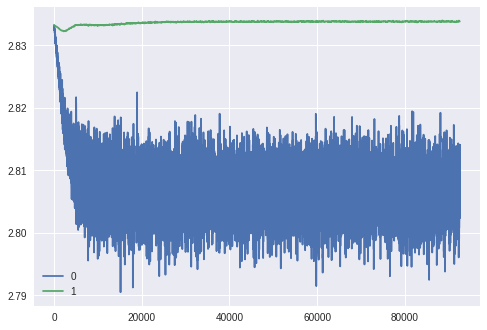

In [0]:
pd.DataFrame(losses).ewm(20).mean().plot()

In [36]:
# np.random.permutation(NB)
# xval[:1].size()
ytrained = net.forward(xval)
# ytrained.size()
if torch.cuda.is_available():
    ytrained = ytrained.cpu()

# plt.imshow(convert(xval[1].cpu().data.numpy().transpose([1,2,0])))
# print(ytrained.data.numpy().T.argmax(axis=0))
# ytrained.data.numpy()
# # oy = ytrained
# # oy == ytrained
# lvaln = lval.cpu().data.numpy()
# lvaln[(lval.cpu().data.numpy().T.argmax(axis=1) ==ytrained.data.numpy().T.argmax(axis=1))].sum(axis=0)
# print (100 * np.mean(lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis =0)))
first_correct = lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis=0)
second_correct = lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argsort(axis=0)[-2]
first_correct.sum(), second_correct.sum(), (first_correct + second_correct).sum()
np.mean(first_correct + second_correct)

a =  lval.cpu().data.numpy().T.argmax(axis=0)
# old_correct = lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis=0)
for i in range(1, 17):
    p = ytrained.data.numpy().T.argsort(axis=0)[-i:]
    t = (p - a) == 0
    t.sum(axis=0)
#     old_correct = old_correct + correct
#     for j in range(1, 17):
    
#     print(np.mean(old_correct))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:121: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [37]:
first_correct = lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis=0)
second_correct = lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argsort(axis=0)[-2]
first_correct.sum(), second_correct.sum(), (first_correct + second_correct).sum()
np.mean(first_correct + second_correct)

old_correct = lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis=0)
for i in range(1, 17):
    correct = lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argsort(axis=0)[-i]
    old_correct = old_correct + correct
    
    print(np.mean(old_correct))

0.25864453665283543
0.34163208852005533
0.4135546334716459
0.48132780082987553
0.5228215767634855
0.5532503457814661
0.6127247579529738
0.6597510373443983
0.6915629322268326
0.7275242047026279
0.7593360995850622
0.7925311203319502
0.8354080221300139
0.8741355463347165
0.91701244813278
0.9515905947441217


Text(0.5,1,u'Confusion matrix for Validation Set')

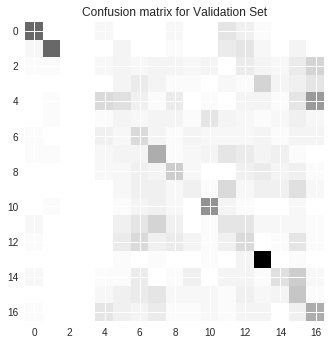

In [41]:
from sklearn.metrics import confusion_matrix

pyplot.imshow(confusion_matrix(lval.cpu().data.numpy().T.argmax(axis=0), ytrained.data.numpy().T.argmax(axis =0)))
plt.title('Confusion matrix for Validation Set')

In [44]:
ytrained = net(xtrain)
if torch.cuda.is_available():
    ytrained = ytrained.cpu()
    
print (100 * np.mean(ltrain.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis =0)))

23.907358983937243


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:121: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Text(0.5,1,u'Confusion matrix for Training set')

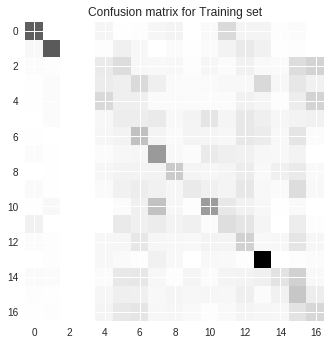

In [46]:
from sklearn.metrics import confusion_matrix

pyplot.imshow(confusion_matrix(ltrain.cpu().data.numpy().T.argmax(axis=0), ytrained.data.numpy().T.argmax(axis =0)),)
plt.title("Confusion matrix for Training set")